In [1]:
!pip install karateclub --quiet
!pip install torch_geometric --quiet
# !pip install shap --quiet

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random

In [3]:
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
##Run in Samriddh's Colab
os.chdir('/content/drive/MyDrive/ALL AutoML Stuff/Samriddh Research Paper/Practice/Final')

#### Parameters for Notebook

In [5]:
buckets, target, toggle_save = 5,'dpd_7_mob_6', True

#### Final Result DataFrame Initilization & Elavuation Metrics

In [6]:
final_results = pd.DataFrame()

In [7]:
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix,
    cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
)
from scipy.stats import ks_2samp

def calculate_metrics(name, y_true, y_test_proba, threshold=0.5):

    # Calculate binary predictions based on the threshold
    y_pred = np.where(y_test_proba >= threshold, 1, 0)

    # Calculate few metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    roc_c = roc_curve(y_true, y_test_proba)
    # roc_c2 = roc_curve(y_true, y_test_proba)
    ks_statistic, ks_p_value = ks_2samp(y_test_proba[y_true == 1], y_test_proba[y_true == 0])

    # Calculate evaluation metrics
    metrics = {
        'ROC Curve': np.asarray(roc_c),
        'AUC-ROC': auc(roc_c[0], roc_c[1]),
        'KS Statistic': ks_statistic,
        'Threshold':threshold,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Specificity': specificity,
        'F1-Score': f1_score(y_true, y_pred),
        'Confusion Matrix': conf_matrix,
        'Cohen\'s Kappa': cohen_kappa_score(y_true, y_pred),
        'Matthews Correlation Coefficient': matthews_corrcoef(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred)
    }

    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=[name])
    metrics_df = metrics_df.reset_index().rename(columns={'index':'Metrics'})

    return metrics_df

### Prediction Using Embeddings

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


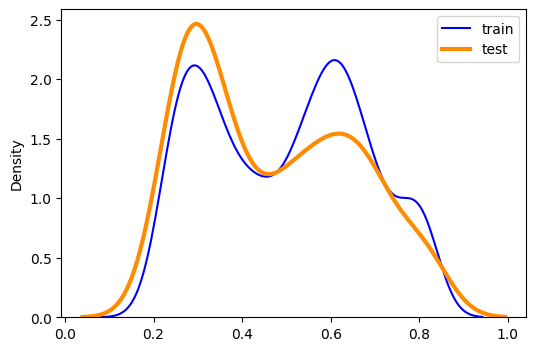

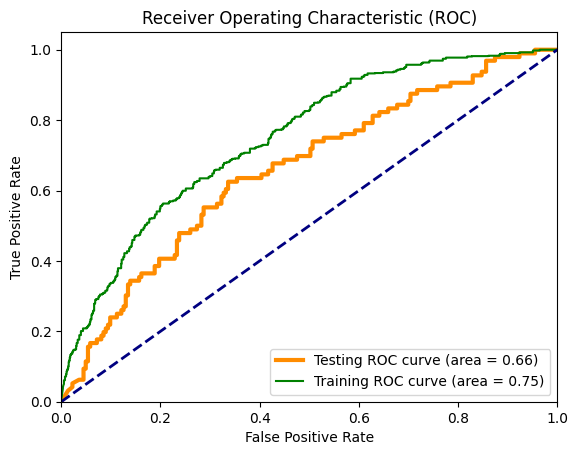

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                    
(0.191, 0.301]         69            370    439      15.717540   
(0.301, 0.419]        170            268    438      38.812785   
(0.419, 0.569]        202            236    438      46.118721   
(0.569, 0.662]        269            172    441      60.997732   
(0.662, 0.824]        322            113    435      74.022989   

                pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                         
(0.191, 0.301]          84.282460             69                370   
(0.301, 0.419]          61.187215            239                638   
(0.419, 0.569]          53.881279            441                874   
(0.569, 0.662]          39.002268            710               1046   
(0.662, 0.824]          25.977011           1032               1159   

                cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                        
(0.191, 0.301]        439          15.717540              84.282460  
(0.301, 0.419]        877          27.251995              72.748005  
(0.419, 0.569]       1315          33.536122              66.463878  
(0.569, 0.662]       1756          40.432802              59.567198  
(0.662, 0.824]       2191          47.101780              52.898220

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                    
(0.191, 0.301]         21            124    145      14.482759   
(0.301, 0.419]         34             98    132      25.757576   
(0.419, 0.569]         45             81    126      35.714286   
(0.569, 0.662]         43             60    103      41.747573   
(0.662, 0.824]         80             52    132      60.606061   

                pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                         
(0.191, 0.301]          85.517241             21                124   
(0.301, 0.419]          74.242424             55                222   
(0.419, 0.569]          64.285714            100                303   
(0.569, 0.662]          58.252427            143                363   
(0.662, 0.824]          39.393939            223                415   

                cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                        
(0.191, 0.301]        145          14.482759              85.517241  
(0.301, 0.419]        277          19.855596              80.144404  
(0.419, 0.569]        403          24.813896              75.186104  
(0.569, 0.662]        506          28.260870              71.739130  
(0.662, 0.824]        638          34.952978              65.047022

In [8]:
# Importing labels
node_label = pd.read_csv("data/node_attributes.csv")[['user_id','dpd_7_mob_6']]
node_label.user_id = node_label.user_id.astype(int)

# Importing sequentially embedded features
features = pd.read_csv("data/rnn_out_nodel_level.csv")
#removing the first 6 columns that are not important
features = features.iloc[:,6:]
features = features.merge(node_label,on='user_id',how='inner')

# Splitting data into train-test
from sklearn.model_selection import train_test_split
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    features.drop(['dpd_7_mob_6'],axis=1), features['dpd_7_mob_6'], test_size=0.2, random_state=42
)


# Create an oversampling object for training data
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

# Fit and transform the training data to oversample the minority class
X_train_over, y_train_over = oversampler.fit_resample(X_train_original, y_train_original)

# Train your model using the oversampled training data
# For testing, use the original test data (do not oversample)
# Evaluate your model's performance on the original test data
X_train = X_train_over.drop('user_id',axis=1)
y_train = y_train_over
X_test = X_test_original.drop('user_id',axis=1)
y_test = y_test_original

# Predicting Probability using Random Forest & performing sigmoid calibration
embedding_col = X_train.columns
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(min_samples_leaf=50, max_depth=3, min_samples_split=200, n_estimators=10, random_state=42)
calibrated = CalibratedClassifierCV(clf, method='sigmoid', cv=3)
calibrated.fit(X_train, y_train)

calibrated.score(X_train, y_train), calibrated.score(X_test, y_test)
y_train_pred = calibrated.predict_proba(X_train)
y_test_pred = calibrated.predict_proba(X_test)

# Calculating all the Metrics
metrics_df = calculate_metrics(
    name = 'Just Embedding Performance',
    y_true = y_test,
    y_test_proba = y_test_pred[:, 1],
)
if(toggle_save == True) :
  final_results = metrics_df
else :
  display(metrics_df)
metrics_df
final_results = metrics_df

# Plotting the probabilities - They Look good and calibrated, awesome 🤩
plt.figure(figsize=(6,4))
sns.kdeplot(y_train_pred[:,1],color = 'blue',label='train',linewidth=1.5)
sns.kdeplot(y_test_pred[:,1], color = 'darkorange',label='test',linewidth=3)
plt.legend()
plt.show()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred[:,1])
roc_auc = auc(fpr, tpr)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred[:,1])
train_roc_auc = auc(train_fpr, train_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot(train_fpr, train_tpr, color='green', lw=1.5, label='Training ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# saving the model-output
train_df = X_train.copy()
test_df = X_test.copy()
train_df[target] = y_train
train_df[['prob0','prob1']] = y_train_pred
test_df[target] = y_test
test_df[['prob0','prob1']] = y_test_pred

# making risk table
df = pd.concat([train_df,test_df],axis=0)
df['score_buckets'] = pd.qcut(df.prob1,q=buckets,duplicates='drop')

# making the training data's risk table
pivot_data = df[df.index.isin(train_df.index)].pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})
pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']
display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])

# making the test data's risk table
pivot_data = df[df.index.isin(test_df.index)].pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})
pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']
display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])


### Predictoin using - Classical Machine Learning

(1873, 40)
(1873,)
(320, 40)
(320,)
mean_amount_M_0_PPOB
mean_amount_M_0_Payment_In
mean_amount_M_0_Payment_Out
mean_amount_M_0_QRIS
mean_amount_M_0_SALDO
mean_amount_M_1_PPOB
mean_amount_M_1_Payment_In
mean_amount_M_1_Payment_Out
mean_amount_M_1_QRIS
mean_amount_M_1_SALDO
mean_amount_M_2_PPOB
mean_amount_M_2_Payment_In
mean_amount_M_2_Payment_Out
mean_amount_M_2_QRIS
mean_amount_M_2_SALDO
mean_amount_M_3_PPOB
mean_amount_M_3_Payment_In
mean_amount_M_3_Payment_Out
mean_amount_M_3_QRIS
mean_amount_M_3_SALDO
sum_amount_M_0_PPOB
sum_amount_M_0_Payment_In
sum_amount_M_0_Payment_Out
sum_amount_M_0_QRIS
sum_amount_M_0_SALDO
sum_amount_M_1_PPOB
sum_amount_M_1_Payment_In
sum_amount_M_1_Payment_Out
sum_amount_M_1_QRIS
sum_amount_M_1_SALDO
sum_amount_M_2_PPOB
sum_amount_M_2_Payment_In
sum_amount_M_2_Payment_Out
sum_amount_M_2_QRIS
sum_amount_M_2_SALDO
sum_amount_M_3_PPOB
sum_amount_M_3_Payment_In
sum_amount_M_3_Payment_Out
sum_amount_M_3_QRIS
sum_amount_M_3_SALDO


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


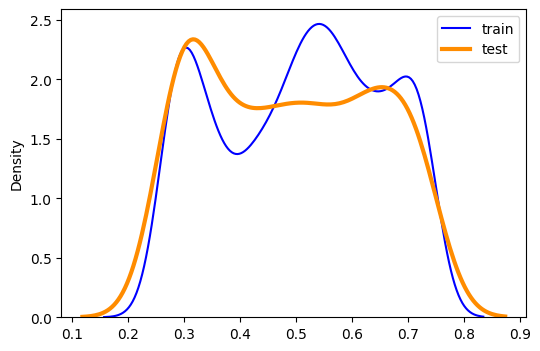

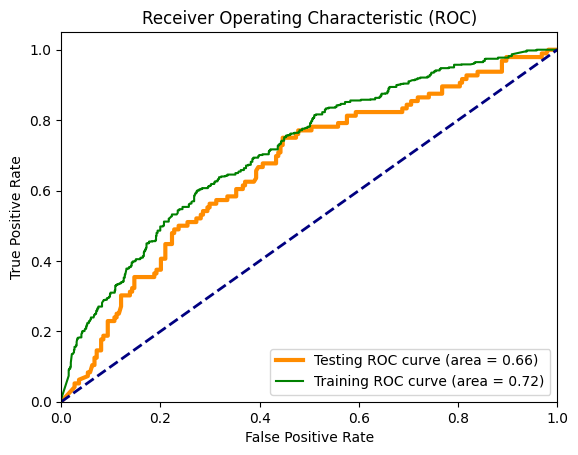

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                    
(0.254, 0.334]         97            342    439      22.095672   
(0.334, 0.471]        152            286    438      34.703196   
(0.471, 0.555]        211            228    439      48.063781   
(0.555, 0.654]        259            180    439      58.997722   
(0.654, 0.738]        313            125    438      71.461187   

                pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                         
(0.254, 0.334]          77.904328             97                342   
(0.334, 0.471]          65.296804            249                628   
(0.471, 0.555]          51.936219            460                856   
(0.555, 0.654]          41.002278            719               1036   
(0.654, 0.738]          28.538813           1032               1161   

                cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                        
(0.254, 0.334]        439          22.095672              77.904328  
(0.334, 0.471]        877          28.392246              71.607754  
(0.471, 0.555]       1316          34.954407              65.045593  
(0.555, 0.654]       1755          40.968661              59.031339  
(0.654, 0.738]       2193          47.058824              52.941176

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                    
(0.254, 0.334]         29            107    136      21.323529   
(0.334, 0.471]         38            111    149      25.503356   
(0.471, 0.555]         38             64    102      37.254902   
(0.555, 0.654]         65             65    130      50.000000   
(0.654, 0.738]         72             51    123      58.536585   

                pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                         
(0.254, 0.334]          78.676471             29                107   
(0.334, 0.471]          74.496644             67                218   
(0.471, 0.555]          62.745098            105                282   
(0.555, 0.654]          50.000000            170                347   
(0.654, 0.738]          41.463415            242                398   

                cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                        
(0.254, 0.334]        136          21.323529              78.676471  
(0.334, 0.471]        285          23.508772              76.491228  
(0.471, 0.555]        387          27.131783              72.868217  
(0.555, 0.654]        517          32.882012              67.117988  
(0.654, 0.738]        640          37.812500              62.187500

In [9]:
# Manual Feature Engineering - Using Classical ML
manual = pd.read_csv("data/node_attributes.csv")
manual.user_id = manual.user_id.astype(int)#.astype(str)

# Dropping the weird column
manual = manual.iloc[:,1:]

# Creating new feature set based on teh same oversampling and train-test split
X_train = X_train_over[['user_id']].merge(manual.drop('dpd_7_mob_6',axis=1)).drop('user_id',axis=1)
y_train = np.squeeze(X_train_over[['user_id']].merge(manual[['user_id','dpd_7_mob_6']]).drop('user_id',axis=1).to_numpy(dtype=int))
X_test = X_test_original[['user_id']].merge(manual.drop('dpd_7_mob_6',axis=1)).drop('user_id',axis=1)
y_test = np.squeeze(X_test_original[['user_id']].merge(manual[['user_id','dpd_7_mob_6']]).drop('user_id',axis=1).to_numpy(dtype=int))
feature_col = X_train.columns

# Printing the shape of each dataframe
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(*feature_col,sep="\n")

# Predicting Probability using Random Forest & performing sigmoid calibration
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(min_samples_leaf=50, max_depth=3, min_samples_split=200, n_estimators=10, random_state=42)
calibrated = CalibratedClassifierCV(clf, method='sigmoid', cv=3)
calibrated.fit(X_train, y_train)
calibrated.score(X_train, y_train), calibrated.score(X_test, y_test)
y_train_pred = calibrated.predict_proba(X_train)
y_test_pred = calibrated.predict_proba(X_test)

# Calculating all the Metrics
metrics_df = calculate_metrics(
    name = 'Classical Machine Learning',
    y_true = y_test,
    y_test_proba = y_test_pred[:, 1],
)
if(toggle_save == True) :
  final_results = final_results.merge(metrics_df)
else :
  display(metrics_df)

# Plotting the probabilities - They Look good and calibrated, awesome 🤩
plt.figure(figsize=(6,4))
sns.kdeplot(y_train_pred[:,1],color = 'blue',label='train',linewidth=1.5)
sns.kdeplot(y_test_pred[:,1], color = 'darkorange',label='test',linewidth=3)
plt.legend()
plt.show()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred[:,1])
roc_auc = auc(fpr, tpr)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred[:,1])
train_roc_auc = auc(train_fpr, train_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot(train_fpr, train_tpr, color='green', lw=1.5, label='Training ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Saving the results of the model
train_df = X_train.copy()
test_df = X_test.copy()
train_df[target] = y_train
train_df[['prob0','prob1']] = y_train_pred
test_df[target] = y_test
test_df[['prob0','prob1']] = y_test_pred
df = pd.concat([train_df,test_df],axis=0)
df['score_buckets'] = pd.qcut(df.prob1,q=buckets,duplicates='drop')

# Making the Risk table for training data
pivot_data = df[df.index.isin(train_df.index)].pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})

pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']

display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])

# Making the Risk table for training data
pivot_data = df[df.index.isin(test_df.index)].pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})

pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']

display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])

### Prediction Using DNN

In [10]:
X_train_tensor = torch.from_numpy(X_train.to_numpy(dtype=np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test.to_numpy(dtype=np.float32 ))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32))

In [11]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([1873, 40])
torch.Size([1873])
torch.Size([320, 40])
torch.Size([320])


In [12]:
epochs = 10
print_step = 1
save_step = 1

hidden_units = 64
hidden_units2 = 32
dropout_rate = 0.2
num_features = len(X_train.columns)
no_of_classes = 1
batch_size = 100

In [13]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Define your neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units2)
        self.fc3 = nn.Linear(hidden_units2, no_of_classes)

    def forward(self, x):
        x = F.dropout(F.relu(self.fc1(x)), p=dropout_rate)
        x = F.dropout(F.relu(self.fc2(x)), p=dropout_rate)
        x = self.fc3(x)

        return F.sigmoid(x)

In [14]:
from torch.utils.data import TensorDataset

# Create TensorDatasets for training and testing data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create an instance of the NeuralNetwork class
model = NeuralNetwork(num_features)

# Define the optimizer (e.g., Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define binary cross-entropy loss
criterion = nn.BCELoss()

# Initialize lists to store train and test loss
train_losses = []
test_losses = []

# Training loop
num_epochs = epochs
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(torch.squeeze(outputs), y_train_tensor)
    loss.backward()
    optimizer.step()

    # Calculate and record test loss
    if (epoch % print_step == 0) or (epoch % save_step == 0):
        with torch.no_grad():
            model.eval()
            test_outputs = model(X_test_tensor)
            test_loss = criterion(torch.squeeze(test_outputs), y_test_tensor)
            if epoch % print_step == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
            if epoch % save_step == 0:
                train_losses.append(loss.item())
                test_losses.append(test_loss.item())


Epoch [1/10], Train Loss: 49.1208, Test Loss: 43.7500
Epoch [2/10], Train Loss: 47.8810, Test Loss: 41.5625
Epoch [3/10], Train Loss: 48.9657, Test Loss: 46.2500
Epoch [4/10], Train Loss: 48.4965, Test Loss: 45.6269
Epoch [5/10], Train Loss: 50.8385, Test Loss: 46.2500
Epoch [6/10], Train Loss: 48.9055, Test Loss: 41.5956
Epoch [7/10], Train Loss: 47.3677, Test Loss: 44.0625
Epoch [8/10], Train Loss: 49.3337, Test Loss: 45.3125
Epoch [9/10], Train Loss: 47.6118, Test Loss: 42.8245
Epoch [10/10], Train Loss: 49.3567, Test Loss: 49.6169


In [15]:
# from torch.utils.data import DataLoader, TensorDataset

# # Create DataLoader for training data
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Create an instance of the NeuralNetwork class
# model = NeuralNetwork(num_features)

# # Define the optimizer (e.g., Adam optimizer)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# # Define binary cross-entropy loss
# criterion = nn.BCELoss()

# # Initialize lists to store train and test loss
# train_losses = []
# test_losses = []

# # Training loop
# num_epochs = epochs
# for epoch in range(num_epochs):
#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(torch.squeeze(outputs), batch_y)
#         loss.backward()
#         optimizer.step()

#     # Calculate and record test loss
#     if (epoch % print_step == 0) | (epoch % save_step == 0) :
#       with torch.no_grad():
#           model.eval()
#           test_outputs = model(X_test_tensor)
#           test_loss = criterion(torch.squeeze(test_outputs), y_test_tensor)
#           if epoch % print_step == 0:
#               print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
#           if epoch % save_step == 0:
#               train_losses.append(loss.item())
#               test_losses.append(test_loss.item())

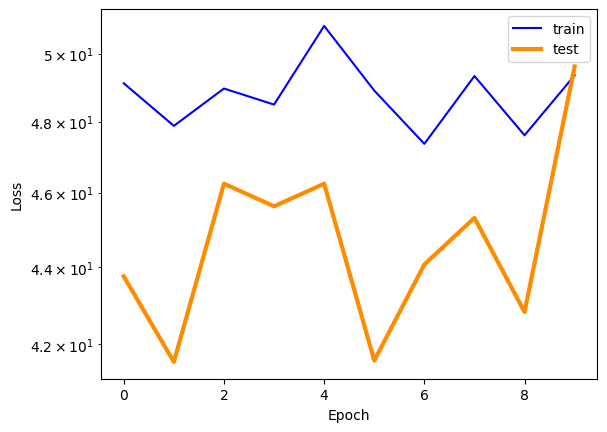

In [16]:
# Plot train and test losses
plt.yscale('log')
plt.plot(train_losses, color='blue', lw=1.5, label='train')
plt.plot(test_losses, color='darkorange', lw=3, label='test')
plt.legend(loc='upper right', title='model type')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
with torch.no_grad():
    model.eval()
    y_train_pred = model(X_train_tensor).detach().numpy()

In [18]:
with torch.no_grad():
    model.eval()
    y_test_pred = model(X_test_tensor).detach().numpy()

In [19]:
y_train_pred = np.squeeze(y_train_pred)
y_test_pred = np.squeeze(y_test_pred)

In [20]:
metrics_df = calculate_metrics(
    name = 'Using Deep Neural Network',
    y_true = y_test,
    y_test_proba = y_test_pred,
    threshold = np.median(y_test_pred)
)

if(toggle_save == True) :
  final_results = final_results.merge(metrics_df)
else :
  display(metrics_df)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


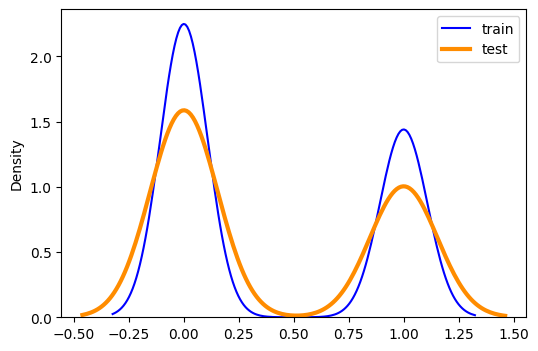

In [21]:
## Plotting the probabilities - They Look good and calibrated, awesome 🤩

plt.figure(figsize=(6,4))
sns.kdeplot(y_train_pred,color = 'blue',label='train',linewidth=1.5)
sns.kdeplot(y_test_pred, color = 'darkorange',label='test',linewidth=3)
plt.legend()
plt.show()

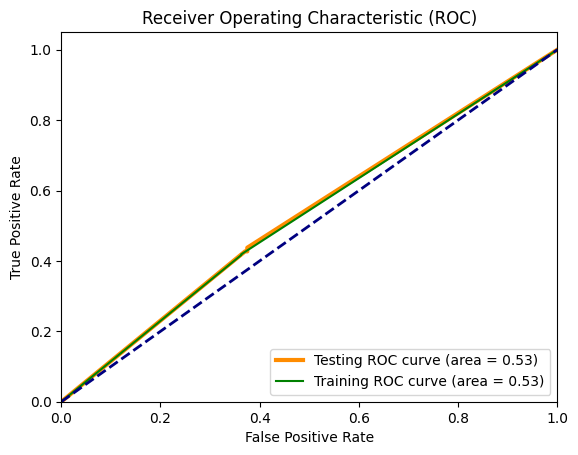

In [22]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
train_roc_auc = auc(train_fpr, train_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot(train_fpr, train_tpr, color='green', lw=1.5, label='Training ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [23]:
train_df = X_train.copy()
test_df = X_test.copy()

train_df[target] = y_train
train_df[['prob1']] = y_train_pred.reshape(-1,1)

test_df[target] = y_test
test_df[['prob1']] = y_test_pred.reshape(-1,1)

In [24]:
df = pd.concat([train_df,test_df],axis=0)
df['score_buckets'] = pd.cut(df.prob1,bins=[0,0.5,1])

In [25]:
pivot_data = df[df.index.isin(train_df.index)].pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})

pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']

display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])
## LoL same name PD :P

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                   
(0.0, 0.5]             2              1      3      66.666667   
(0.5, 1.0]           432            423    855      50.526316   

               pct_non_defaulter  cum_defaulter  cum_non_defaulter  cum_total  \
score_buckets                                                                   
(0.0, 0.5]             33.333333              2                  1          3   
(0.5, 1.0]             49.473684            434                424        858   

               cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                            
(0.0, 0.5]             66.666667              33.333333  
(0.5, 1.0]             50.582751              49.417249

In [26]:
pivot_data = df[df.index.isin(test_df.index)].pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})

pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']

display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])
## LoL same name PD :P

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                   
(0.0, 0.5]             1              1      2      50.000000   
(0.5, 1.0]           100            142    242      41.322314   

               pct_non_defaulter  cum_defaulter  cum_non_defaulter  cum_total  \
score_buckets                                                                   
(0.0, 0.5]             50.000000              1                  1          2   
(0.5, 1.0]             58.677686            101                143        244   

               cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                            
(0.0, 0.5]             50.000000              50.000000  
(0.5, 1.0]             41.393443              58.606557

### Prediction using Pseudo Graph Neural Network with Multi-edge Time-aware Aggregation

#### Making the Node Based Graph Structure

In [27]:
edge = pd.read_csv("data/edge_data.csv",names=['source','target','weight'],skiprows=1)

In [28]:
edge.shape

(2333, 3)

In [29]:
edge.head(2)

source       target  weight
0  81111111185  81111111185     103
1   8115934524   8115934524       1

In [30]:
node_attributes = pd.read_csv("data/node_attributes.csv")

In [31]:
node_attributes = node_attributes.iloc[:,1:]

In [32]:
print("Node attributes shape:", node_attributes.shape)
node_attributes.head()

Node attributes shape: (1595, 42)


user_id  mean_amount_M_0_PPOB  mean_amount_M_0_Payment_In  \
0  81111111185          32192.500000                         0.0   
1    811666821          31410.000000                         0.0   
2    811784808         176000.192308                         0.0   
3   8118622401              0.000000                         0.0   
4    811899969          67026.377778                         0.0   

   mean_amount_M_0_Payment_Out  mean_amount_M_0_QRIS  mean_amount_M_0_SALDO  \
0                 2.191277e+07          1.507429e+06                98636.0   
1                 5.564164e+06          0.000000e+00                68639.0   
2                 9.363182e+05          3.675000e+05                    0.0   
3                 6.892477e+05          0.000000e+00                    0.0   
4                 4.582354e+06          0.000000e+00               750000.0   

   mean_amount_M_1_PPOB  mean_amount_M_1_Payment_In  \
0          16799.333333                         0.0   
1          30048.333333                         0.0   
2         149932.815534                         0.0   
3          41336.500000                         0.0   
4          76091.040000                         0.0   

   mean_amount_M_1_Payment_Out  mean_amount_M_1_QRIS  ...  \
0                 1.730180e+07          1.423021e+06  ...   
1                 4.167113e+06          0.000000e+00  ...   
2                 1.653327e+06          2.285714e+05  ...   
3                 7.631314e+05          0.000000e+00  ...   
4                 4.824064e+06          0.000000e+00  ...   

   sum_amount_M_2_Payment_In  sum_amount_M_2_Payment_Out  sum_amount_M_2_QRIS  \
0                        0.0                0.000000e+00                  0.0   
1                        0.0                2.881464e+09                  0.0   
2                        0.0                0.000000e+00                  0.0   
3                        0.0                2.489909e+08                  0.0   
4                        0.0                1.128557e+09                  0.0   

   sum_amount_M_2_SALDO  sum_amount_M_3_PPOB  sum_amount_M_3_Payment_In  \
0                   0.0                  0.0                        0.0   
1                   0.0                  0.0                        0.0   
2                   0.0                  0.0                        0.0   
3                   0.0                  0.0                        0.0   
4             3000000.0            3664100.0                        0.0   

   sum_amount_M_3_Payment_Out  sum_amount_M_3_QRIS  sum_amount_M_3_SALDO  \
0                0.000000e+00                  0.0                   0.0   
1                2.929478e+09                  0.0                   0.0   
2                0.000000e+00                  0.0                   0.0   
3                2.766100e+08                  0.0                   0.0   
4                1.078563e+09                  0.0             2600000.0   

   dpd_7_mob_6  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 42 columns]

In [33]:
edge = edge[edge.source.isin(node_attributes.user_id.astype(int))]
edge = edge[edge.target.isin(node_attributes.user_id.astype(int))]

In [34]:
edge.shape

(1634, 3)

In [35]:
user_idc = {name: idx for idx, name in enumerate(sorted(node_attributes["user_id"].unique()))}

node_attributes["user_id"] = node_attributes["user_id"].apply(lambda name: user_idc[name])
edge["source"] = edge["source"].apply(lambda name: user_idc[name])
edge["target"] = edge["target"].apply(lambda name: user_idc[name])

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
colors = node_attributes["dpd_7_mob_6"].tolist()

In [37]:
cora_graph = nx.from_pandas_edgelist(edge,source='source', target='target',edge_attr='weight')

In [38]:
len(cora_graph.nodes)

1175

In [39]:
#nodes missing from the graphs
new_nodes = node_attributes[~node_attributes.user_id.isin(list(cora_graph.nodes))].user_id

In [40]:
len(new_nodes)

419

In [41]:
new_nodes

7         73
23        17
24        90
27        94
41       113
        ... 
1574    1035
1578    1593
1579     744
1582    1491
1586     742
Name: user_id, Length: 419, dtype: int64

In [42]:
cora_graph.add_nodes_from(new_nodes)

In [43]:
len(cora_graph.nodes)

1594

In [44]:
node_attributes.user_id.nunique(), node_attributes.user_id.shape[0]

(1594, 1595)

In [45]:
node_attributes = node_attributes.drop_duplicates()

In [46]:
node_attributes.dpd_7_mob_6.isnull().sum()

0

Creating Graph Structural Embeddings (For node based graph) - Deep Walk

In [47]:
from sklearn.decomposition import PCA
from karateclub import DeepWalk

# train model and generate embedding
model = DeepWalk(walk_length=10, dimensions=64, window_size=3)
model.fit(cora_graph)
embedding = model.get_embedding()

In [48]:
embeddings = pd.DataFrame(embedding)
embeddings = embeddings.add_prefix("G_struc_emb_")
embeddings = embeddings.reset_index().rename(columns={'index':'user_idc'})

In [49]:
embeddings.head(2)

user_idc  G_struc_emb_0  G_struc_emb_1  G_struc_emb_2  G_struc_emb_3  \
0         0       0.019878       0.630160       0.852478       0.526062   
1         1       0.532351      -0.272571       1.815735       0.959695   

   G_struc_emb_4  G_struc_emb_5  G_struc_emb_6  G_struc_emb_7  G_struc_emb_8  \
0       1.027455      -0.424986      -0.675834      -0.209423       0.661619   
1       1.193284      -0.148708      -1.710203      -1.007895       0.041972   

   ...  G_struc_emb_54  G_struc_emb_55  G_struc_emb_56  G_struc_emb_57  \
0  ...       -0.343686       -0.293230       -0.221368        0.174254   
1  ...       -1.352662       -0.213458        0.184817       -0.983776   

   G_struc_emb_58  G_struc_emb_59  G_struc_emb_60  G_struc_emb_61  \
0       -1.147621        0.672582        0.893794       -0.083127   
1       -0.262390        0.993917        0.558609       -0.950409   

   G_struc_emb_62  G_struc_emb_63  
0        0.306696        0.254410  
1        0.151189        0.522768  

[2 rows x 65 columns]

Evaluating Local Graph Features

In [50]:
# load node attribute & label
node_attributes['degree'] = node_attributes.user_id.map(nx.degree(cora_graph))
node_attributes['degree_centrality'] = node_attributes.user_id.map(nx.degree_centrality(cora_graph))
node_attributes['closeness_centrality'] = node_attributes.user_id.map(nx.closeness_centrality(cora_graph))
node_attributes['betweenness_centrality'] = node_attributes.user_id.map(nx.betweenness_centrality(cora_graph))

In [51]:
node_attributes = node_attributes.merge(embeddings, left_on='user_id',right_on='user_idc')

In [52]:
max(user_idc.values())

1593

Creating Training & Test Mask

In [53]:
test_users_idc = X_test_original.user_id.astype(int).map(user_idc).values

node_attributes['test_mask'] = node_attributes.user_id.isin(test_users_idc).astype(int)
node_attributes['train_mask'] = (~node_attributes.user_id.isin(test_users_idc)).astype(int)

In [54]:
node_attributes.test_mask.sum() + node_attributes.train_mask.sum()

1594

In [55]:
edge.rename(columns={'target':'destination'},inplace=True)

#### Model 1 : Node Level – Leaky Graph Structure – UnWeighted

In [56]:
'''
Vectorizing the graph data
'''
# edge
edge_adj_coo =  torch.from_numpy(edge[['source', 'destination']].to_numpy(np.compat.long)).t()


# node-attribute
feature_names = node_attributes.drop(['user_id','user_idc','dpd_7_mob_6','train_mask','test_mask'],axis=1).columns
node_feat = torch.from_numpy(node_attributes[feature_names].to_numpy(np.float32))
# node_feat = torch.from_numpy(node_attributes[range(64)].to_numpy(np.float32))

# label
label = torch.from_numpy(node_attributes[target].to_numpy(np.float32)).unsqueeze(1)

# making masks
train_mask = torch.from_numpy(node_attributes['train_mask'].to_numpy(np.int32))
test_mask = torch.from_numpy(node_attributes['test_mask'].to_numpy(np.int32))

In [57]:
from torch_geometric.data import Data

data = Data(
    x = node_feat,
    edge_index = edge_adj_coo,
    # edge_attr = edge_attr,
    # edge_wt = edge_wt,
    y = label,
    train_mask = train_mask,
    test_mask = test_mask,
)

In [58]:
data

Data(x=[1594, 108], edge_index=[2, 1634], y=[1594, 1], train_mask=[1594], test_mask=[1594])

In [59]:
data.num_features

108

**Model Construction & Training : Graph Convolution Network (Sigmoid & BCE)**

In [60]:
epochs = 20
print_step = 1
save_step = 1

In [61]:
hidden_units = 32
dropout_rate = 0.2
num_features = data.num_features #data.x.shape[1]
no_of_classes = 1

# num_classes = len(class_idc)
# hidden_units = [32, 32]
# learning_rate = 0.01
# dropout_rate = 0.5
# num_epochs = 20
# batch_size = 100

In [62]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,Sequential,Linear,BatchNorm
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.preprocessing1 = nn.BatchNorm1d(num_features)
        self.preprocessing2 = nn.Dropout(dropout_rate)
        self.preprocessing3 = nn.Linear(num_features, hidden_units)
        self.preprocessing4 = nn.GELU()

        self.conv1 = GCNConv(hidden_units, hidden_units)
        self.conv2 = GCNConv(hidden_units, hidden_units)

        self.postprocessing1 = nn.BatchNorm1d(hidden_units)
        self.postprocessing2 = nn.Dropout(dropout_rate)
        self.postprocessing3 = nn.Linear(hidden_units, hidden_units)
        self.postprocessing4 = nn.GELU()

        self.logits = Linear(hidden_units, no_of_classes)

    def forward(self, data):

        # x, edge_index, edge_weight = data.x, data.edge_index, data.edge_wt

        x, edge_index  = data.x, data.edge_index

        x = self.preprocessing1(x)
        x = self.preprocessing2(x)
        x = self.preprocessing3(x)
        x = self.preprocessing4(x)

        x = self.conv1(x, edge_index)
        # x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        # x = self.conv1(x, edge_index, edge_weight)


        x = self.postprocessing1(x)
        x = self.postprocessing2(x)
        x = self.postprocessing3(x)
        x = self.postprocessing4(x)

        x = self.logits(x)

        return torch.sigmoid(x)

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = list()
val_losses = list()

model.train()

criterion = torch.nn.BCELoss()

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)

    # loss = criterion(out, data.y)
    loss = criterion(out*data.train_mask, data.y*data.train_mask)
    val_loss = F.binary_cross_entropy(out*data.test_mask,data.y*test_mask)

    if epoch % print_step == 0:
      print("Epoch : {a} \n   Training Loss : {b}\n   Validation Loss : {c}".format(a=epoch,b=loss,c=val_loss))

    if epoch % save_step == 0:
      losses.append((epoch, loss.detach().numpy()))
      val_losses.append((epoch,val_loss.detach().numpy()))

    if epoch % save_step == 0:
        # save predictions for plotting
        model.eval()

    loss.backward()
    optimizer.step()

Epoch : 0 
   Training Loss : 0.5273386240005493
   Validation Loss : 0.13193804025650024
Epoch : 1 
   Training Loss : 0.4918311834335327
   Validation Loss : 0.12305423617362976
Epoch : 2 
   Training Loss : 0.46338582038879395
   Validation Loss : 0.11593730747699738
Epoch : 3 
   Training Loss : 0.4715351462364197
   Validation Loss : 0.11797622591257095
Epoch : 4 
   Training Loss : 0.4486197531223297
   Validation Loss : 0.11224290728569031
Epoch : 5 
   Training Loss : 0.44738370180130005
   Validation Loss : 0.11193365603685379
Epoch : 6 
   Training Loss : 0.4498119056224823
   Validation Loss : 0.11254115402698517
Epoch : 7 
   Training Loss : 0.4456416666507721
   Validation Loss : 0.11149779707193375
Epoch : 8 
   Training Loss : 0.43971389532089233
   Validation Loss : 0.11001469194889069
Epoch : 9 
   Training Loss : 0.43882715702056885
   Validation Loss : 0.10979283601045609
Epoch : 10 
   Training Loss : 0.43792667984962463
   Validation Loss : 0.10956753045320511
Epoc

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

def comparison_plot(losses,val_losses):
    '''
    Plot the trajectory of a model's training from a dataframe that has train/val loss at each epoch.
    '''
    plt.yscale('log')

    epoch, loss = tuple(zip(*losses))
    val_epoch, val_loss = tuple(zip(*val_losses))
    plt.plot(epoch, loss, color='blue', lw=1.5, label='train')
    plt.plot(val_epoch, val_loss, color='darkorange', lw=3, label='val')
    plt.legend(loc='upper right', title='model type')
    # plt.yscale('log')
    plt.ylabel('Binary Cross Entrophy')
    plt.xlabel('epoch')
    # plt.title(f'Comparing baseline and model with edge features')
    plt.show()
    plt.clf()

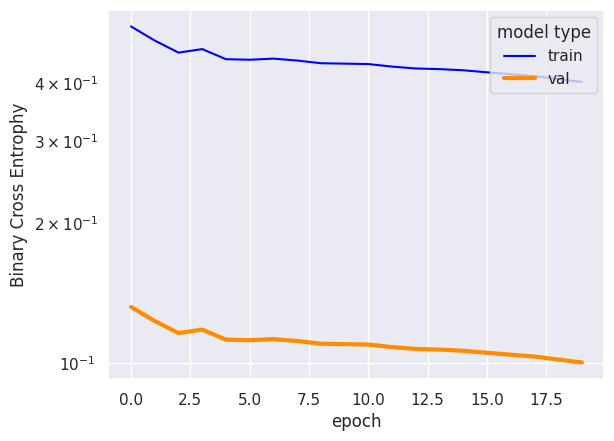

<Figure size 640x480 with 0 Axes>

In [65]:
comparison_plot(losses,val_losses)

In [66]:
with torch.no_grad():
  model.eval()
  out = model(data)

In [67]:
df = node_attributes.copy()

In [68]:
df[['prob1']] = out.numpy()

In [69]:
df[['prob1']].describe()

prob1
count  1.594000e+03
mean   2.718109e-01
std    1.453309e-01
min    3.241463e-16
25%    1.489962e-01
50%    2.894509e-01
75%    4.036188e-01
max    7.741727e-01

In [70]:
y_train = df.loc[df.train_mask==1,target]
y_train_proba = df.loc[df.train_mask==1,'prob1']

y_test = df.loc[df.test_mask==1,target]
y_test_proba = df.loc[df.test_mask==1,'prob1']

In [71]:
metrics_df = calculate_metrics(
    name = 'Node Level – Leaky Graph Structure – UnWeighted (Model 1)',
    y_true = y_test,
    y_test_proba = df.loc[df.test_mask==1,'prob1'],
    threshold = np.median(df.loc[df.test_mask==1,'prob1'])
)

if(toggle_save == True) :
  final_results = final_results.merge(metrics_df)
else :
  display(metrics_df)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


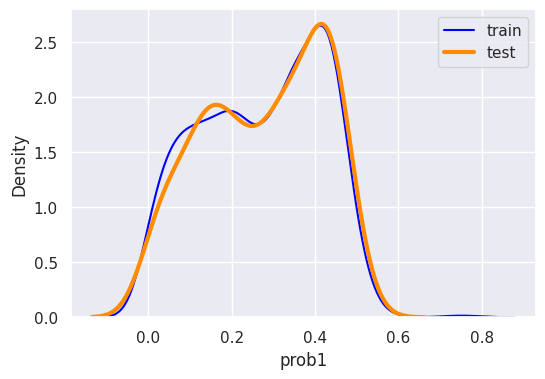

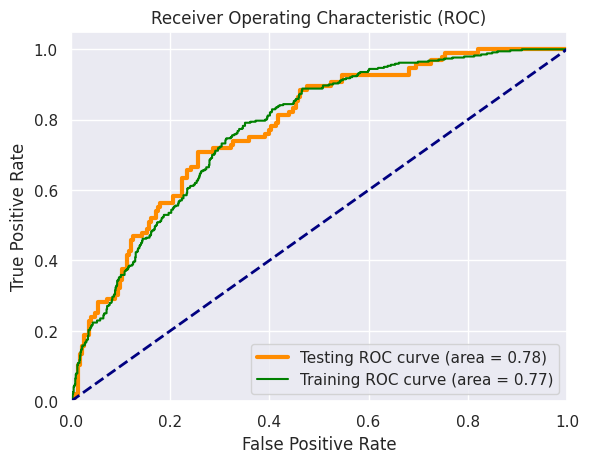

defaulter  non_defaulter  total  \
score_buckets                                                     
(-0.000999999999999676, 0.123]         11            248    259   
(0.123, 0.227]                         27            228    255   
(0.227, 0.339]                         64            190    254   
(0.339, 0.419]                        105            152    257   
(0.419, 0.774]                        133            117    250   

                                pct_defaulter  pct_non_defaulter  \
score_buckets                                                      
(-0.000999999999999676, 0.123]       4.247104          95.752896   
(0.123, 0.227]                      10.588235          89.411765   
(0.227, 0.339]                      25.196850          74.803150   
(0.339, 0.419]                      40.856031          59.143969   
(0.419, 0.774]                      53.200000          46.800000   

                                cum_defaulter  cum_non_defaulter  cum_total  \
score_buckets                                                                 
(-0.000999999999999676, 0.123]             11                248        259   
(0.123, 0.227]                             38                476        514   
(0.227, 0.339]                            102                666        768   
(0.339, 0.419]                            207                818       1025   
(0.419, 0.774]                            340                935       1275   

                                cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                             
(-0.000999999999999676, 0.123]           4.247104              95.752896  
(0.123, 0.227]                           7.392996              92.607004  
(0.227, 0.339]                          13.281250              86.718750  
(0.339, 0.419]                          20.195122              79.804878  
(0.419, 0.774]                          26.666667              73.333333

defaulter  non_defaulter  total  \
score_buckets                                                     
(-0.000999999999999676, 0.123]          3             57     60   
(0.123, 0.227]                          7             57     64   
(0.227, 0.339]                         18             46     64   
(0.339, 0.419]                         26             36     62   
(0.419, 0.774]                         42             27     69   

                                pct_defaulter  pct_non_defaulter  \
score_buckets                                                      
(-0.000999999999999676, 0.123]       5.000000          95.000000   
(0.123, 0.227]                      10.937500          89.062500   
(0.227, 0.339]                      28.125000          71.875000   
(0.339, 0.419]                      41.935484          58.064516   
(0.419, 0.774]                      60.869565          39.130435   

                                cum_defaulter  cum_non_defaulter  cum_total  \
score_buckets                                                                 
(-0.000999999999999676, 0.123]              3                 57         60   
(0.123, 0.227]                             10                114        124   
(0.227, 0.339]                             28                160        188   
(0.339, 0.419]                             54                196        250   
(0.419, 0.774]                             96                223        319   

                                cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                             
(-0.000999999999999676, 0.123]           5.000000              95.000000  
(0.123, 0.227]                           8.064516              91.935484  
(0.227, 0.339]                          14.893617              85.106383  
(0.339, 0.419]                          21.600000              78.400000  
(0.419, 0.774]                          30.094044              69.905956

In [72]:
# Plotting the probabilities - They Look good and calibrated, awesome 🤩
plt.figure(figsize=(6,4))
sns.kdeplot(y_train_proba,color = 'blue',label='train',linewidth=1.5)
sns.kdeplot(y_test_proba, color = 'darkorange',label='test',linewidth=3)
plt.legend()
plt.show()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_proba)
train_roc_auc = auc(train_fpr, train_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot(train_fpr, train_tpr, color='green', lw=1.5, label='Training ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#
df['score_buckets'] = pd.qcut(df.prob1,q=buckets,duplicates='drop')
df_test = df[df.test_mask==1]
df_train = df[df.train_mask==1]

# Making the training Risk Table
pivot_data = df_train.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})
pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']
display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])

# Making the test Risk Table
pivot_data = df_test.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})
pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']
display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])


#### Model 2 : Node Level – Leaky Graph Structure – Weighted

In [73]:
'''
Vectorizing the graph data
'''
# edge
edge_adj_coo =  torch.from_numpy(edge[['source', 'destination']].to_numpy(np.compat.long)).t()

# I can add weights, later but
edge_wt = torch.from_numpy(edge.loc[:,'weight'].to_numpy(np.float32))

# node-attribute
feature_names = node_attributes.drop(['user_id','user_idc','dpd_7_mob_6','train_mask','test_mask'],axis=1).columns
node_feat = torch.from_numpy(node_attributes[feature_names].to_numpy(np.float32))

# label
label = torch.from_numpy(node_attributes[target].to_numpy(np.float32)).unsqueeze(1)

# making masks
train_mask = torch.from_numpy(node_attributes['train_mask'].to_numpy(np.int32))
test_mask = torch.from_numpy(node_attributes['test_mask'].to_numpy(np.int32))

In [74]:
from torch_geometric.data import Data

data = Data(
    x = node_feat,
    edge_index = edge_adj_coo,
    edge_wt = edge_wt,
    y = label,
    train_mask = train_mask,
    test_mask = test_mask,
)

In [75]:
data

Data(x=[1594, 108], edge_index=[2, 1634], y=[1594, 1], edge_wt=[1634], train_mask=[1594], test_mask=[1594])

In [76]:
data.num_features

108

**Model Construction & Training : Graph Convolution Network (Sigmoid & BCE)**

In [77]:
epochs = 20
print_step = 1
save_step = 1

In [78]:
hidden_units = 32
dropout_rate = 0.2
num_features = data.num_features #data.x.shape[1]
no_of_classes = 1

# num_classes = len(class_idc)
# hidden_units = [32, 32]
# learning_rate = 0.01
# dropout_rate = 0.5
# num_epochs = 20
# batch_size = 100

In [79]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,Sequential,Linear,BatchNorm
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.preprocessing1 = nn.BatchNorm1d(num_features)
        self.preprocessing2 = nn.Dropout(dropout_rate)
        self.preprocessing3 = nn.Linear(num_features, hidden_units)
        self.preprocessing4 = nn.GELU()

        self.conv1 = GCNConv(hidden_units, hidden_units)
        self.conv2 = GCNConv(hidden_units, hidden_units)

        self.postprocessing1 = nn.BatchNorm1d(hidden_units)
        self.postprocessing2 = nn.Dropout(dropout_rate)
        self.postprocessing3 = nn.Linear(hidden_units, hidden_units)
        self.postprocessing4 = nn.GELU()

        self.logits = Linear(hidden_units, no_of_classes)

    def forward(self, data):

        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_wt

        x = self.preprocessing1(x)
        x = self.preprocessing2(x)
        x = self.preprocessing3(x)
        x = self.preprocessing4(x)

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv1(x, edge_index, edge_weight)


        x = self.postprocessing1(x)
        x = self.postprocessing2(x)
        x = self.postprocessing3(x)
        x = self.postprocessing4(x)

        x = self.logits(x)

        return torch.sigmoid(x)

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = list()
val_losses = list()

model.train()

criterion = torch.nn.BCELoss()

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)

    # loss = criterion(out, data.y)
    loss = criterion(out*data.train_mask, data.y*data.train_mask)
    val_loss = F.binary_cross_entropy(out*data.test_mask,data.y*test_mask)

    if epoch % print_step == 0:
      print("Epoch : {a} \n   Training Loss : {b}\n   Validation Loss : {c}".format(a=epoch,b=loss,c=val_loss))

    if epoch % save_step == 0:
      losses.append((epoch, loss.detach().numpy()))
      val_losses.append((epoch,val_loss.detach().numpy()))

    if epoch % save_step == 0:
        # save predictions for plotting
        model.eval()

    loss.backward()
    optimizer.step()

Epoch : 0 
   Training Loss : 0.5740231275558472
   Validation Loss : 0.1436183601617813
Epoch : 1 
   Training Loss : 0.5500200986862183
   Validation Loss : 0.13761287927627563
Epoch : 2 
   Training Loss : 0.5101375579833984
   Validation Loss : 0.1276344209909439
Epoch : 3 
   Training Loss : 0.4726991057395935
   Validation Loss : 0.11826746165752411
Epoch : 4 
   Training Loss : 0.4843326807022095
   Validation Loss : 0.12117812782526016
Epoch : 5 
   Training Loss : 0.46645888686180115
   Validation Loss : 0.11670617759227753
Epoch : 6 
   Training Loss : 0.45226606726646423
   Validation Loss : 0.11315519362688065
Epoch : 7 
   Training Loss : 0.45363306999206543
   Validation Loss : 0.11349720507860184
Epoch : 8 
   Training Loss : 0.4528736174106598
   Validation Loss : 0.11330720782279968
Epoch : 9 
   Training Loss : 0.44649043679237366
   Validation Loss : 0.11171015352010727
Epoch : 10 
   Training Loss : 0.4408893287181854
   Validation Loss : 0.11030878126621246
Epoch :

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

def comparison_plot(losses,val_losses):
    '''
    Plot the trajectory of a model's training from a dataframe that has train/val loss at each epoch.
    '''
    plt.yscale('log')

    epoch, loss = tuple(zip(*losses))
    val_epoch, val_loss = tuple(zip(*val_losses))
    plt.plot(epoch, loss, color='blue', lw=1.5, label='train')
    plt.plot(val_epoch, val_loss, color='darkorange', lw=3, label='val')
    plt.legend(loc='upper right', title='model type')
    # plt.yscale('log')
    plt.ylabel('Binary Cross Entrophy')
    plt.xlabel('epoch')
    # plt.title(f'Comparing baseline and model with edge features')
    plt.show()
    plt.clf()

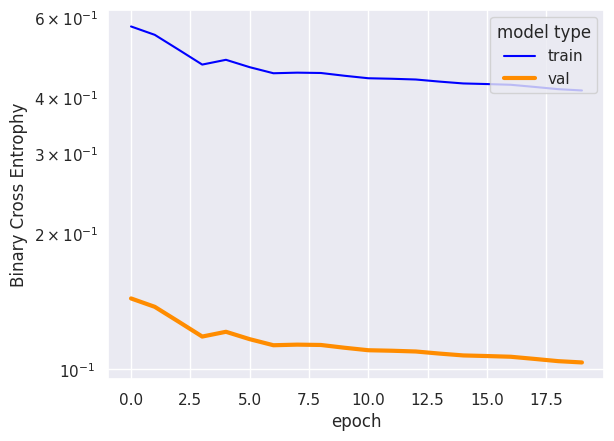

<Figure size 640x480 with 0 Axes>

In [82]:
comparison_plot(losses,val_losses)

In [83]:
with torch.no_grad():
  model.eval()
  out = model(data)

In [84]:
df = node_attributes.copy()

In [85]:
df[['prob1']] = out.numpy()

In [86]:
df[['prob1']].describe()

prob1
count  1.594000e+03
mean   2.425697e-01
std    1.390573e-01
min    7.042177e-08
25%    1.379673e-01
50%    2.352820e-01
75%    3.453066e-01
max    9.999799e-01

In [87]:
y_train = df.loc[df.train_mask==1,target]
y_train_proba = df.loc[df.train_mask==1,'prob1']

y_test = df.loc[df.test_mask==1,target]
y_test_proba = df.loc[df.test_mask==1,'prob1']

In [88]:
metrics_df = calculate_metrics(
    name = 'Node Level – Leaky Graph Structure – Weighted (Model 2)',
    y_true = y_test,
    y_test_proba = df.loc[df.test_mask==1,'prob1'],
    threshold = np.median(df.loc[df.test_mask==1,'prob1'])
)

if(toggle_save == True) :
  final_results = final_results.merge(metrics_df)
else :
  display(metrics_df)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


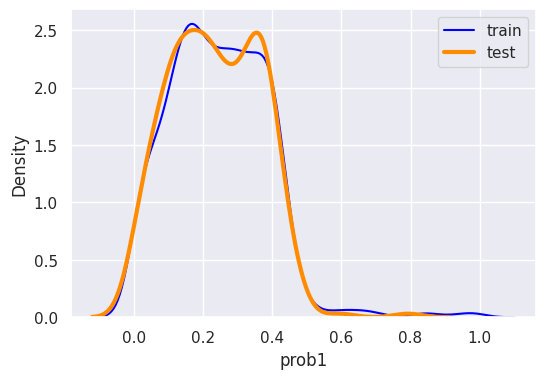

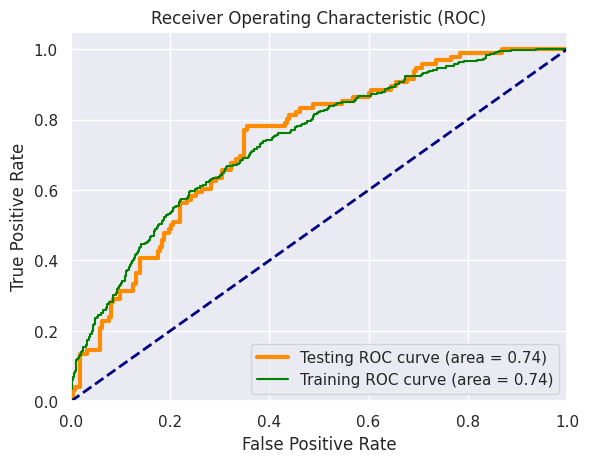

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                            
(-0.0009999296, 0.118]         18            233    251       7.171315   
(0.118, 0.192]                 39            218    257      15.175097   
(0.192, 0.281]                 59            194    253      23.320158   
(0.281, 0.366]                 84            170    254      33.070866   
(0.366, 1.0]                  140            120    260      53.846154   

                        pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                                 
(-0.0009999296, 0.118]          92.828685             18                233   
(0.118, 0.192]                  84.824903             57                451   
(0.192, 0.281]                  76.679842            116                645   
(0.281, 0.366]                  66.929134            200                815   
(0.366, 1.0]                    46.153846            340                935   

                        cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                                
(-0.0009999296, 0.118]        251           7.171315              92.828685  
(0.118, 0.192]                508          11.220472              88.779528  
(0.192, 0.281]                761          15.243101              84.756899  
(0.281, 0.366]               1015          19.704433              80.295567  
(0.366, 1.0]                 1275          26.666667              73.333333

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                            
(-0.0009999296, 0.118]          4             64     68       5.882353   
(0.118, 0.192]                 12             50     62      19.354839   
(0.192, 0.281]                 20             45     65      30.769231   
(0.281, 0.366]                 29             36     65      44.615385   
(0.366, 1.0]                   31             28     59      52.542373   

                        pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                                 
(-0.0009999296, 0.118]          94.117647              4                 64   
(0.118, 0.192]                  80.645161             16                114   
(0.192, 0.281]                  69.230769             36                159   
(0.281, 0.366]                  55.384615             65                195   
(0.366, 1.0]                    47.457627             96                223   

                        cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                                
(-0.0009999296, 0.118]         68           5.882353              94.117647  
(0.118, 0.192]                130          12.307692              87.692308  
(0.192, 0.281]                195          18.461538              81.538462  
(0.281, 0.366]                260          25.000000              75.000000  
(0.366, 1.0]                  319          30.094044              69.905956

In [89]:
# Plotting the probabilities - They Look good and calibrated, awesome 🤩
plt.figure(figsize=(6,4))
sns.kdeplot(y_train_proba,color = 'blue',label='train',linewidth=1.5)
sns.kdeplot(y_test_proba, color = 'darkorange',label='test',linewidth=3)
plt.legend()
plt.show()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_proba)
train_roc_auc = auc(train_fpr, train_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot(train_fpr, train_tpr, color='green', lw=1.5, label='Training ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#
df['score_buckets'] = pd.qcut(df.prob1,q=buckets,duplicates='drop')
df_test = df[df.test_mask==1]
df_train = df[df.train_mask==1]

# Making the training Risk Table
pivot_data = df_train.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})
pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']
display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])

# Making the test Risk Table
pivot_data = df_test.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})
pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']
display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])


#### Model 3 : Node Level – UnLeaky Graph Structure – UnWeighted

In [90]:
graph_structure_feature_names = ["G_struc_emb_"+str(i) for i in range(64)]

In [91]:
 node_feature_names = set(node_attributes.drop(['user_id','user_idc','dpd_7_mob_6','train_mask','test_mask'],axis=1).columns) - set(["G_struc_emb_"+str(i) for i in range(64)])

In [92]:
'''
Vectorizing the graph data
'''
# edge
edge_adj_coo =  torch.from_numpy(edge[['source', 'destination']].to_numpy(np.compat.long)).t()

# node-attribute
node_feat = torch.from_numpy(node_attributes[node_feature_names].to_numpy(np.float32))

# graph_structure (deep_walk)
graph_structure = torch.from_numpy(node_attributes[graph_structure_feature_names].to_numpy(np.float32))

# label
label = torch.from_numpy(node_attributes[target].to_numpy(np.float32)).unsqueeze(1)

# making masks
train_mask = torch.from_numpy(node_attributes['train_mask'].to_numpy(np.int32))
test_mask = torch.from_numpy(node_attributes['test_mask'].to_numpy(np.int32))

In [93]:
from torch_geometric.data import Data

data = Data(
    x = node_feat,
    edge_index = edge_adj_coo,
    y = label,
    graph_structure = graph_structure,
    train_mask = train_mask,
    test_mask = test_mask,
)

In [94]:
data

Data(x=[1594, 44], edge_index=[2, 1634], y=[1594, 1], graph_structure=[1594, 64], train_mask=[1594], test_mask=[1594])

In [95]:
data.num_features

44

Model Construction & Training : Graph Convolution Network (Sigmoid & BCE)
bold text



In [96]:
epochs = 51
print_step = 5
save_step = 10

In [97]:
hidden_units = 32
dropout_rate = 0.5
num_features = data.num_features #data.x.shape[1]
no_of_classes = 1
no_of_graph_embedding = data.graph_structure.shape[1]

# num_classes = len(class_idc)
# hidden_units = [32, 32]
# learning_rate = 0.01
# dropout_rate = 0.5
# num_epochs = 20
# batch_size = 100

In [98]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,Sequential,Linear,BatchNorm
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.preprocessing1 = nn.BatchNorm1d(num_features)
        self.preprocessing2 = nn.Dropout(dropout_rate)
        self.preprocessing3 = nn.Linear(num_features, hidden_units)
        self.preprocessing4 = nn.GELU()

        self.conv1 = GCNConv(hidden_units, hidden_units)
        self.conv2 = GCNConv(hidden_units, hidden_units)

        self.postprocessing1 = nn.BatchNorm1d(hidden_units+no_of_graph_embedding)
        self.postprocessing2 = nn.Dropout(dropout_rate)
        self.postprocessing3 = nn.Linear(hidden_units+no_of_graph_embedding, hidden_units)
        self.postprocessing4 = nn.GELU()

        self.logits = Linear(hidden_units, no_of_classes)

    def forward(self, data):

        x, edge_index, graph_structure = data.x, data.edge_index, data.graph_structure

        x = self.preprocessing1(x)
        x = self.preprocessing2(x)
        x = self.preprocessing3(x)
        x = self.preprocessing4(x)

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        #concatinating the graph structure, becuse we dont want neightbours graph structure to influence my graph structure representation & in GNN layer, that would have happened
        x = torch.cat((x,graph_structure),dim=1)

        x = self.postprocessing1(x)
        x = self.postprocessing2(x)
        x = self.postprocessing3(x)
        x = self.postprocessing4(x)

        x = self.logits(x)

        return torch.sigmoid(x)

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = list()
val_losses = list()

model.train()

criterion = torch.nn.BCELoss()

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)

    # loss = criterion(out, data.y)
    loss = criterion(out*data.train_mask, data.y*data.train_mask)
    val_loss = F.binary_cross_entropy(out*data.test_mask,data.y*test_mask)

    if epoch % print_step == 0:
      print("Epoch : {a} \n   Training Loss : {b}\n   Validation Loss : {c}".format(a=epoch,b=loss,c=val_loss))

    if epoch % save_step == 0:
      losses.append((epoch, loss.detach().numpy()))
      val_losses.append((epoch,val_loss.detach().numpy()))

    if epoch % save_step == 0:
        # save predictions for plotting
        model.eval()

    loss.backward()
    optimizer.step()

Epoch : 0 
   Training Loss : 0.5310021638870239
   Validation Loss : 0.1328546553850174
Epoch : 5 
   Training Loss : 0.44849297404289246
   Validation Loss : 0.1122111976146698
Epoch : 10 
   Training Loss : 0.4403378367424011
   Validation Loss : 0.11017081141471863
Epoch : 15 
   Training Loss : 0.43095603585243225
   Validation Loss : 0.10782350599765778
Epoch : 20 
   Training Loss : 0.41844090819358826
   Validation Loss : 0.10469228029251099
Epoch : 25 
   Training Loss : 0.39915886521339417
   Validation Loss : 0.09986798465251923
Epoch : 30 
   Training Loss : 0.3759331703186035
   Validation Loss : 0.09405700117349625
Epoch : 35 
   Training Loss : 0.35862961411476135
   Validation Loss : 0.0897277295589447
Epoch : 40 
   Training Loss : 0.34744495153427124
   Validation Loss : 0.08692935854196548
Epoch : 45 
   Training Loss : 0.33597531914711
   Validation Loss : 0.0840597152709961
Epoch : 50 
   Training Loss : 0.32291659712791443
   Validation Loss : 0.08079247176647186


In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Plotting the losses
def comparison_plot(losses,val_losses):
    '''
    Plot the trajectory of a model's training from a dataframe that has train/val loss at each epoch.
    '''
    plt.yscale('log')

    epoch, loss = tuple(zip(*losses))
    val_epoch, val_loss = tuple(zip(*val_losses))
    plt.plot(epoch, loss, color='blue', lw=1.5, label='train')
    plt.plot(val_epoch, val_loss, color='darkorange', lw=3, label='val')
    plt.legend(loc='upper right', title='model type')
    # plt.yscale('log')
    plt.ylabel('Binary Cross Entrophy')
    plt.xlabel('epoch')
    # plt.title(f'Comparing baseline and model with edge features')
    plt.show()
    plt.clf()

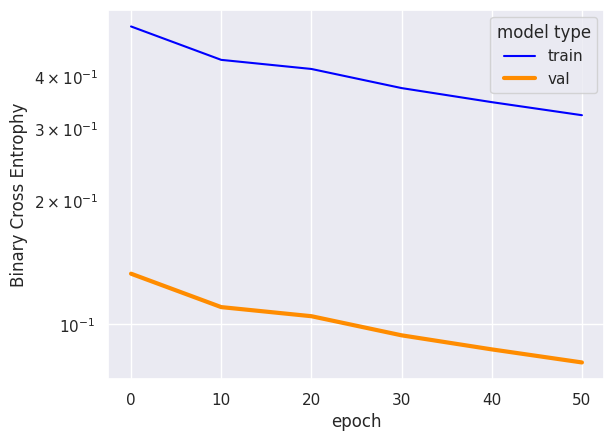

<Figure size 640x480 with 0 Axes>

In [101]:
comparison_plot(losses,val_losses)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


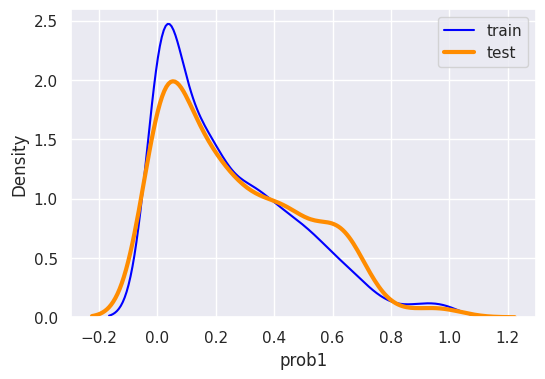

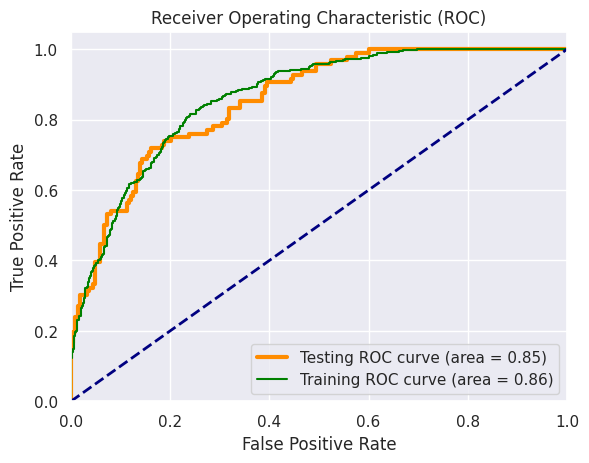

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                      
(-0.001, 0.0265]          0            260    260       0.000000   
(0.0265, 0.123]          19            239    258       7.364341   
(0.123, 0.264]           45            211    256      17.578125   
(0.264, 0.456]          110            147    257      42.801556   
(0.456, 1.0]            166             78    244      68.032787   

                  pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                           
(-0.001, 0.0265]         100.000000              0                260   
(0.0265, 0.123]           92.635659             19                499   
(0.123, 0.264]            82.421875             64                710   
(0.264, 0.456]            57.198444            174                857   
(0.456, 1.0]              31.967213            340                935   

                  cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                          
(-0.001, 0.0265]        260           0.000000             100.000000  
(0.0265, 0.123]         518           3.667954              96.332046  
(0.123, 0.264]          774           8.268734              91.731266  
(0.264, 0.456]         1031          16.876819              83.123181  
(0.456, 1.0]           1275          26.666667              73.333333

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                      
(-0.001, 0.0265]          0             59     59       0.000000   
(0.0265, 0.123]           6             55     61       9.836066   
(0.123, 0.264]           16             46     62      25.806452   
(0.264, 0.456]           22             40     62      35.483871   
(0.456, 1.0]             52             23     75      69.333333   

                  pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                           
(-0.001, 0.0265]         100.000000              0                 59   
(0.0265, 0.123]           90.163934              6                114   
(0.123, 0.264]            74.193548             22                160   
(0.264, 0.456]            64.516129             44                200   
(0.456, 1.0]              30.666667             96                223   

                  cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                          
(-0.001, 0.0265]         59           0.000000             100.000000  
(0.0265, 0.123]         120           5.000000              95.000000  
(0.123, 0.264]          182          12.087912              87.912088  
(0.264, 0.456]          244          18.032787              81.967213  
(0.456, 1.0]            319          30.094044              69.905956

In [102]:
# Saving the model output
with torch.no_grad():
  model.eval()
  out = model(data)
df = node_attributes.copy()
df[['prob1']] = out.numpy()
df[['prob1']].describe()
y_train = df.loc[df.train_mask==1,target]
y_train_proba = df.loc[df.train_mask==1,'prob1']
y_test = df.loc[df.test_mask==1,target]
y_test_proba = df.loc[df.test_mask==1,'prob1']


# Calculating the Metrics
metrics_df = calculate_metrics(
    name = 'Node Level – UnLeaky Graph Structure – UnWeighted (Model 3)',
    y_true = y_test,
    y_test_proba = df.loc[df.test_mask==1,'prob1'],
    threshold = np.median(df.loc[df.test_mask==1,'prob1'])
)
if(toggle_save == True) :
  final_results = final_results.merge(metrics_df)
else :
  display(metrics_df)


## Plotting the probabilities - They Look good and calibrated, awesome 🤩
plt.figure(figsize=(6,4))
sns.kdeplot(y_train_proba,color = 'blue',label='train',linewidth=1.5)
sns.kdeplot(y_test_proba, color = 'darkorange',label='test',linewidth=3)
plt.legend()
plt.show()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_proba)
train_roc_auc = auc(train_fpr, train_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot(train_fpr, train_tpr, color='green', lw=1.5, label='Training ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Making the Risk Tables
df['score_buckets'] = pd.qcut(df.prob1,q=buckets,duplicates='drop')
df_test = df[df.test_mask==1]
df_train = df[df.train_mask==1]

# Making the training Risk Table
pivot_data = df_train.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})
pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']
display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])

# Making the test Risk Table
pivot_data = df_test.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})
pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']
display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])
## LoL same name PD :P

#### Model 4 : Node Level – UnLeaky Graph Structure – Weighted

In [103]:
graph_structure_feature_names = ["G_struc_emb_"+str(i) for i in range(64)]

In [104]:
 node_feature_names = set(node_attributes.drop(['user_id','user_idc','dpd_7_mob_6','train_mask','test_mask'],axis=1).columns) - set(["G_struc_emb_"+str(i) for i in range(64)])

In [105]:
'''
Vectorizing the graph data
'''
# edge
edge_adj_coo =  torch.from_numpy(edge[['source', 'destination']].to_numpy(np.compat.long)).t()

# edge-attributes
edge_wt = torch.from_numpy(edge.loc[:,'weight'].to_numpy(np.float32))

# node-attribute
node_feat = torch.from_numpy(node_attributes[node_feature_names].to_numpy(np.float32))

# graph_structure (deep_walk)
graph_structure = torch.from_numpy(node_attributes[graph_structure_feature_names].to_numpy(np.float32))

# label
label = torch.from_numpy(node_attributes[target].to_numpy(np.float32)).unsqueeze(1)

# making masks
train_mask = torch.from_numpy(node_attributes['train_mask'].to_numpy(np.int32))
test_mask = torch.from_numpy(node_attributes['test_mask'].to_numpy(np.int32))

In [106]:
from torch_geometric.data import Data

data = Data(
    x = node_feat,
    edge_index = edge_adj_coo,
    # edge_attr = edge_attr,
    edge_wt = edge_wt,
    y = label,
    graph_structure = graph_structure,
    train_mask = train_mask,
    test_mask = test_mask,
)

In [107]:
data

Data(x=[1594, 44], edge_index=[2, 1634], y=[1594, 1], edge_wt=[1634], graph_structure=[1594, 64], train_mask=[1594], test_mask=[1594])

In [108]:
data.num_features

44

Model Construction & Training : Graph Convolution Network (Sigmoid & BCE)

In [109]:
epochs = 51
print_step = 5
save_step = 10

In [110]:
hidden_units = 32
dropout_rate = 0.5
num_features = data.num_features #data.x.shape[1]
no_of_classes = 1
no_of_graph_embedding = data.graph_structure.shape[1]

# num_classes = len(class_idc)
# hidden_units = [32, 32]
# learning_rate = 0.01
# dropout_rate = 0.5
# num_epochs = 20
# batch_size = 100

In [111]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,Sequential,Linear,BatchNorm
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.preprocessing1 = nn.BatchNorm1d(num_features)
        self.preprocessing2 = nn.Dropout(dropout_rate)
        self.preprocessing3 = nn.Linear(num_features, hidden_units)
        self.preprocessing4 = nn.GELU()

        self.conv1 = GCNConv(hidden_units, hidden_units)
        self.conv2 = GCNConv(hidden_units, hidden_units)

        self.postprocessing1 = nn.BatchNorm1d(hidden_units+no_of_graph_embedding)
        self.postprocessing2 = nn.Dropout(dropout_rate)
        self.postprocessing3 = nn.Linear(hidden_units+no_of_graph_embedding, hidden_units)
        self.postprocessing4 = nn.GELU()

        self.logits = Linear(hidden_units, no_of_classes)

    def forward(self, data):

        x, edge_index, edge_weight, graph_structure = data.x, data.edge_index, data.edge_wt, data.graph_structure

        x = self.preprocessing1(x)
        x = self.preprocessing2(x)
        x = self.preprocessing3(x)
        x = self.preprocessing4(x)

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)

        #concatinating the graph structure, becuse we dont want neightbours graph structure to influence my graph structure representation & in GNN layer, that would have happened
        x = torch.cat((x,graph_structure),dim=1)

        x = self.postprocessing1(x)
        x = self.postprocessing2(x)
        x = self.postprocessing3(x)
        x = self.postprocessing4(x)

        x = self.logits(x)

        return torch.sigmoid(x)

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = list()
val_losses = list()

model.train()

criterion = torch.nn.BCELoss()

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)

    # loss = criterion(out, data.y)
    loss = criterion(out*data.train_mask, data.y*data.train_mask)
    val_loss = F.binary_cross_entropy(out*data.test_mask,data.y*test_mask)

    if epoch % print_step == 0:
      print("Epoch : {a} \n   Training Loss : {b}\n   Validation Loss : {c}".format(a=epoch,b=loss,c=val_loss))

    if epoch % save_step == 0:
      losses.append((epoch, loss.detach().numpy()))
      val_losses.append((epoch,val_loss.detach().numpy()))

    if epoch % save_step == 0:
        # save predictions for plotting
        model.eval()

    loss.backward()
    optimizer.step()

Epoch : 0 
   Training Loss : 0.597105085849762
   Validation Loss : 0.14939336478710175
Epoch : 5 
   Training Loss : 0.45101138949394226
   Validation Loss : 0.11284127831459045
Epoch : 10 
   Training Loss : 0.43825215101242065
   Validation Loss : 0.10964897274971008
Epoch : 15 
   Training Loss : 0.42551684379577637
   Validation Loss : 0.10646262019872665
Epoch : 20 
   Training Loss : 0.4090021550655365
   Validation Loss : 0.10233073681592941
Epoch : 25 
   Training Loss : 0.395318865776062
   Validation Loss : 0.0989072173833847
Epoch : 30 
   Training Loss : 0.38001400232315063
   Validation Loss : 0.09507802128791809
Epoch : 35 
   Training Loss : 0.3804994821548462
   Validation Loss : 0.09519948065280914
Epoch : 40 
   Training Loss : 0.40077248215675354
   Validation Loss : 0.10027169436216354
Epoch : 45 
   Training Loss : 0.39292678236961365
   Validation Loss : 0.0983087345957756
Epoch : 50 
   Training Loss : 0.3808092474937439
   Validation Loss : 0.09527698159217834

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Plotting the losses
def comparison_plot(losses,val_losses):
    '''
    Plot the trajectory of a model's training from a dataframe that has train/val loss at each epoch.
    '''
    plt.yscale('log')

    epoch, loss = tuple(zip(*losses))
    val_epoch, val_loss = tuple(zip(*val_losses))
    plt.plot(epoch, loss, color='blue', lw=1.5, label='train')
    plt.plot(val_epoch, val_loss, color='darkorange', lw=3, label='val')
    plt.legend(loc='upper right', title='model type')
    # plt.yscale('log')
    plt.ylabel('Binary Cross Entrophy')
    plt.xlabel('epoch')
    # plt.title(f'Comparing baseline and model with edge features')
    plt.show()
    plt.clf()

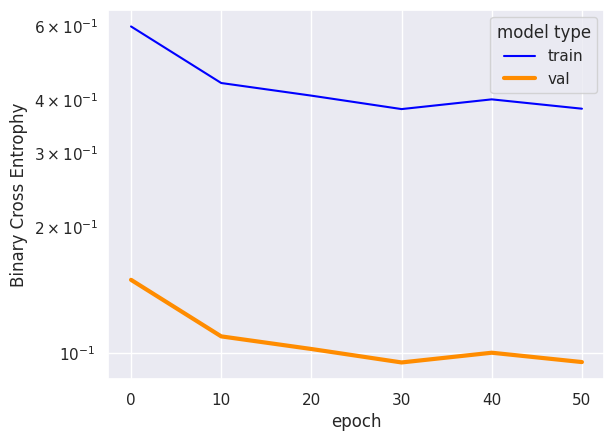

<Figure size 640x480 with 0 Axes>

In [114]:
comparison_plot(losses,val_losses)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


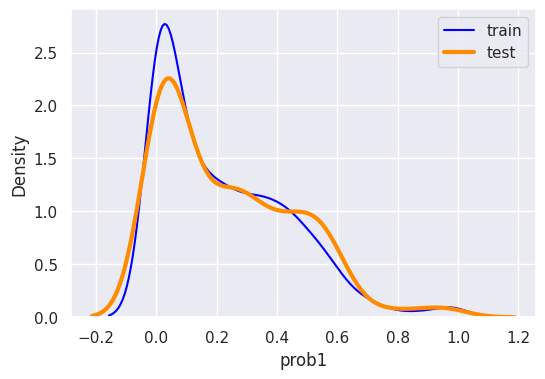

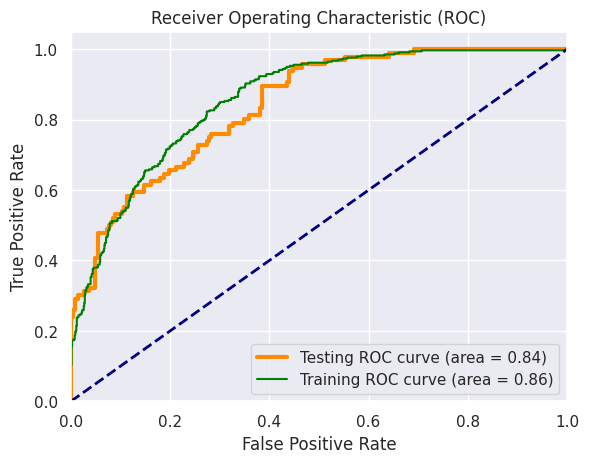

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                      
(-0.001, 0.0148]          1            255    256       0.390625   
(0.0148, 0.0987]         13            242    255       5.098039   
(0.0987, 0.249]          60            202    262      22.900763   
(0.249, 0.431]           94            162    256      36.718750   
(0.431, 1.0]            172             74    246      69.918699   

                  pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                           
(-0.001, 0.0148]          99.609375              1                255   
(0.0148, 0.0987]          94.901961             14                497   
(0.0987, 0.249]           77.099237             74                699   
(0.249, 0.431]            63.281250            168                861   
(0.431, 1.0]              30.081301            340                935   

                  cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                          
(-0.001, 0.0148]        256           0.390625              99.609375  
(0.0148, 0.0987]        511           2.739726              97.260274  
(0.0987, 0.249]         773           9.573092              90.426908  
(0.249, 0.431]         1029          16.326531              83.673469  
(0.431, 1.0]           1275          26.666667              73.333333

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                      
(-0.001, 0.0148]          0             63     63       0.000000   
(0.0148, 0.0987]          5             59     64       7.812500   
(0.0987, 0.249]          18             38     56      32.142857   
(0.249, 0.431]           22             41     63      34.920635   
(0.431, 1.0]             51             22     73      69.863014   

                  pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                           
(-0.001, 0.0148]         100.000000              0                 63   
(0.0148, 0.0987]          92.187500              5                122   
(0.0987, 0.249]           67.857143             23                160   
(0.249, 0.431]            65.079365             45                201   
(0.431, 1.0]              30.136986             96                223   

                  cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                          
(-0.001, 0.0148]         63           0.000000             100.000000  
(0.0148, 0.0987]        127           3.937008              96.062992  
(0.0987, 0.249]         183          12.568306              87.431694  
(0.249, 0.431]          246          18.292683              81.707317  
(0.431, 1.0]            319          30.094044              69.905956

In [115]:
# Saving the model output
with torch.no_grad():
  model.eval()
  out = model(data)
df = node_attributes.copy()
df[['prob1']] = out.numpy()
df[['prob1']].describe()
y_train = df.loc[df.train_mask==1,target]
y_train_proba = df.loc[df.train_mask==1,'prob1']
y_test = df.loc[df.test_mask==1,target]
y_test_proba = df.loc[df.test_mask==1,'prob1']


# Calculating the Metrics
metrics_df = calculate_metrics(
    name = 'Node Level – UnLeaky Graph Structure – Weighted (Model 4)',
    y_true = y_test,
    y_test_proba = df.loc[df.test_mask==1,'prob1'],
    threshold = np.median(df.loc[df.test_mask==1,'prob1'])
)
if(toggle_save == True) :
  final_results = final_results.merge(metrics_df)
else :
  display(metrics_df)


## Plotting the probabilities - They Look good and calibrated, awesome 🤩
plt.figure(figsize=(6,4))
sns.kdeplot(y_train_proba,color = 'blue',label='train',linewidth=1.5)
sns.kdeplot(y_test_proba, color = 'darkorange',label='test',linewidth=3)
plt.legend()
plt.show()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_proba)
train_roc_auc = auc(train_fpr, train_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot(train_fpr, train_tpr, color='green', lw=1.5, label='Training ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Making the Risk Tables
df['score_buckets'] = pd.qcut(df.prob1,q=buckets,duplicates='drop')
df_test = df[df.test_mask==1]
df_train = df[df.train_mask==1]

# Making the training Risk Table
pivot_data = df_train.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})
pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']
display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])

# Making the test Risk Table
pivot_data = df_test.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})
pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']
display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])
## LoL same name PD :P

#### Making Edge Based Graph Structure

In [116]:
'''
Extracting the graph data
'''
# Load edge data
edge =  pd.read_csv("data/rnn_out_edge_based_256Rd.csv").drop(['Unnamed: 0'],axis=1).drop(['pair_id','time_delta','event_time','txn_type_id','amount','edge_pair'],axis=1)
edge = edge.sort_values('source',axis=0,ascending=True)
edge.source = edge.source.astype(int).astype(str)
edge.destination = edge.destination.astype(str)

# Encoding source & destination
list_total = pd.concat([edge.source,edge.destination]).sort_values(ascending=False).unique()
user_idc = {name: idx for idx, name in enumerate(list_total)}
edge["source"] = edge["source"].apply(lambda name: user_idc[name])
edge["destination"] = edge["destination"].apply(lambda name: user_idc[name])

# Making graph nx
attr = list(set(edge.columns)- set(['source','destination']))
cora_graph = nx.from_pandas_edgelist(edge,source='source', target='destination')

# Load node attribute
node = pd.DataFrame(nx.degree(cora_graph),columns=['node_idx','degree'])
node['degree_centrality'] = node.node_idx.map(nx.degree_centrality(cora_graph))
node = node.sort_values('node_idx',ascending=True).reset_index(drop=True)

# Load label
node_label = pd.read_csv("data/node_attributes.csv")[['user_id','dpd_7_mob_6']]
node_label.user_id = node_label.user_id.astype(int).astype(str)
node_label['user_id'] = node_label['user_id'].apply(lambda name: user_idc[str(name)])
node_label = node.merge(node_label,left_on='node_idx', right_on='user_id',how='left')
node_label['target_mask'] = node_label.dpd_7_mob_6.notnull().astype(int)
node_label.dpd_7_mob_6 = node_label.dpd_7_mob_6.fillna(2) #### ************************** NOTE

'''
Eliminating 1 data anomaly
'''
#some issue of 1 user is extra in labels than in edge lists
#removing that user
# node_label[node_label.node_idx==9759] #-> this is the user with double entry
node_label = node_label.drop_duplicates('node_idx')

Creating Embeddings for Graph Structure (For Edge Based Graph) - Deep Walk

In [117]:
from sklearn.decomposition import PCA
from karateclub import DeepWalk

# train model and generate embedding
model = DeepWalk(walk_length=10, dimensions=64, window_size=3,seed=42)
model.fit(cora_graph)
embedding = model.get_embedding()

embeddings = pd.DataFrame(embedding)
embeddings = embeddings.add_prefix("G_struc_emb_")

Creating Train & Test Mask

In [118]:
'''
Making the mask
'''
test_users_idc = X_test_original.user_id.astype(str).map(user_idc).values
node_label['test_mask'] = node_label.node_idx.isin(test_users_idc).astype(int)
node_label['train_mask'] = ((~node_label.node_idx.isin(test_users_idc)) & (node_label.target_mask==1)).astype(int)

#### Model 5 : Edge Level – Leaky Graph Structure – UnWeighted

In [119]:
'''
Vectorizing the graph data
'''
#edge
edge_adj_coo =  torch.from_numpy(edge[['source', 'destination']].to_numpy(np.compat.long)).t()

#edge-attributes
edge_attr = torch.from_numpy(edge.iloc[:,:-2].to_numpy(np.float32)) #extract the features from the dataset.

#node-attribute
node_feat = torch.from_numpy(node[['degree','degree_centrality']].to_numpy(np.float32))

#graph_structure
graph_structure = torch.from_numpy(embeddings.to_numpy(np.float32))

#label
label = torch.from_numpy(node_label['dpd_7_mob_6'].to_numpy(np.float32)).unsqueeze(1)

#vectorizing the mask
train_mask  = torch.from_numpy(node_label[['train_mask']].to_numpy(np.int32))
test_mask   = torch.from_numpy(node_label[['test_mask']].to_numpy(np.int32))

In [120]:
from torch_geometric.data import Data

data = Data(
    x = node_feat,
    edge_index = edge_adj_coo,
    edge_attr = edge_attr,
    # edge_wt = edge_wt,
    y = label,
    graph_structure = graph_structure,
    train_mask = train_mask,
    test_mask = test_mask,
)

In [121]:
data

Data(x=[11367, 2], edge_index=[2, 25141], edge_attr=[25141, 256], y=[11367, 1], graph_structure=[11367, 64], train_mask=[11367, 1], test_mask=[11367, 1])

In [122]:
data.num_features

2

Model Construction & Training : Graph Attention Network (Sigmoid & BCE)

In [123]:
epochs = 20
print_step = 2
save_step = 1

In [124]:
hidden_units = 64 # for edge
hidden_units_node_attr = 4
dropout_rate = 0.2
num_features = data.num_features #data.x.shape[1]
no_of_classes = 1
no_of_graph_embedding = data.graph_structure.shape[1]
no_of_edge_features = data.edge_attr.shape[1]

In [125]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,Sequential,Linear,BatchNorm
import torch.nn as nn
from torch_geometric.nn import GATConv
import torch_geometric.transforms as T


class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.preprocessing1 = nn.BatchNorm1d(no_of_edge_features)
        self.preprocessing2 = nn.Dropout(dropout_rate)
        self.preprocessing3 = nn.Linear(no_of_edge_features, hidden_units)
        self.preprocessing4 = nn.GELU()

        self.conv1 = GATConv(in_channels = num_features+no_of_graph_embedding, out_channels = hidden_units_node_attr, edge_dim = hidden_units)
        self.conv2 = GATConv(in_channels = hidden_units_node_attr, out_channels = hidden_units_node_attr, edge_dim = hidden_units)

        self.postprocessing1 = nn.BatchNorm1d(hidden_units_node_attr)
        self.postprocessing2 = nn.Dropout(dropout_rate)
        self.postprocessing3 = nn.Linear(hidden_units_node_attr, hidden_units)
        self.postprocessing4 = nn.GELU()

        self.logits = Linear(hidden_units, no_of_classes)


    def forward(self, data):

        x, edge_index, edge_attr, graph_embedding = data.x, data.edge_index, data.edge_attr, data.graph_structure

        edge_attr = self.preprocessing1(edge_attr)
        edge_attr = self.preprocessing2(edge_attr)
        edge_attr = self.preprocessing3(edge_attr)
        edge_attr = self.preprocessing4(edge_attr)

        x = torch.cat((x,graph_embedding),dim=1)

        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=dropout_rate ,training=self.training)
        x = self.conv2(x, edge_index, edge_attr=edge_attr)

        x = self.postprocessing1(x)
        x = self.postprocessing2(x)
        x = self.postprocessing3(x)
        x = self.postprocessing4(x)

        x = self.logits(x)

        return torch.sigmoid(x)

In [126]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = list()
val_losses = list()

model.train()

criterion = torch.nn.BCELoss()

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)

    # loss = criterion(out, data.y)
    loss = criterion(out*data.train_mask, data.y*data.train_mask)
    val_loss = F.binary_cross_entropy(out*data.test_mask,data.y*test_mask)

    if epoch % print_step == 0:
      print("Epoch : {a} \n   Training Loss : {b}\n   Validation Loss : {c}".format(a=epoch,b=loss,c=val_loss))

    if epoch % save_step == 0:
      losses.append((epoch, loss.detach().numpy()))
      val_losses.append((epoch,val_loss.detach().numpy()))

    if epoch % save_step == 0:
        # save predictions for plotting
        model.eval()

    loss.backward()
    optimizer.step()

Epoch : 0 
   Training Loss : 0.07863934338092804
   Validation Loss : 0.01966768689453602
Epoch : 2 
   Training Loss : 0.07306141406297684
   Validation Loss : 0.01849326118826866
Epoch : 4 
   Training Loss : 0.06550253182649612
   Validation Loss : 0.017471112310886383
Epoch : 6 
   Training Loss : 0.06403613835573196
   Validation Loss : 0.017826704308390617
Epoch : 8 
   Training Loss : 0.06502503156661987
   Validation Loss : 0.018573183566331863
Epoch : 10 
   Training Loss : 0.06481539458036423
   Validation Loss : 0.018579011783003807
Epoch : 12 
   Training Loss : 0.06355950981378555
   Validation Loss : 0.018019016832113266
Epoch : 14 
   Training Loss : 0.06270071864128113
   Validation Loss : 0.01748233661055565
Epoch : 16 
   Training Loss : 0.06253138929605484
   Validation Loss : 0.017183462157845497
Epoch : 18 
   Training Loss : 0.0625464916229248
   Validation Loss : 0.017051633447408676


In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

def comparison_plot(losses,val_losses):
    '''
    Plot the trajectory of a model's training from a dataframe that has train/val loss at each epoch.
    '''
    plt.yscale('log')

    epoch, loss = tuple(zip(*losses))
    val_epoch, val_loss = tuple(zip(*val_losses))
    plt.plot(epoch, loss, color='blue', lw=1.5, label='train')
    plt.plot(val_epoch, val_loss, color='darkorange', lw=3, label='val')
    plt.legend(loc='upper right', title='model type')
    # plt.yscale('log')
    plt.ylabel('Binary Cross Entrophy')
    plt.xlabel('epoch')
    # plt.title(f'Comparing baseline and model with edge features')
    plt.show()
    plt.clf()

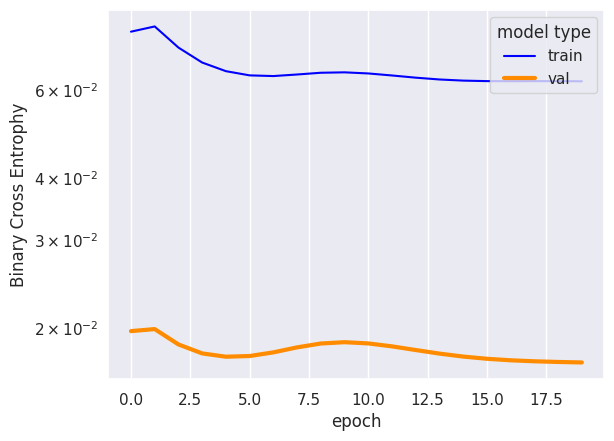

<Figure size 640x480 with 0 Axes>

In [128]:
comparison_plot(losses,val_losses)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


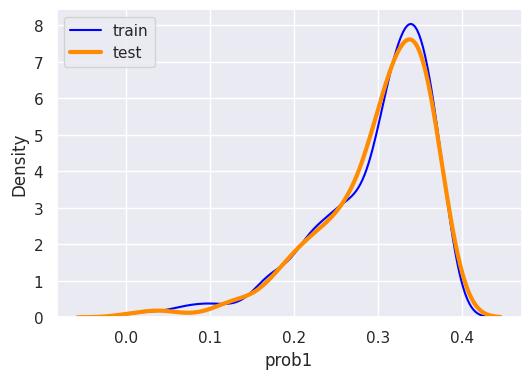

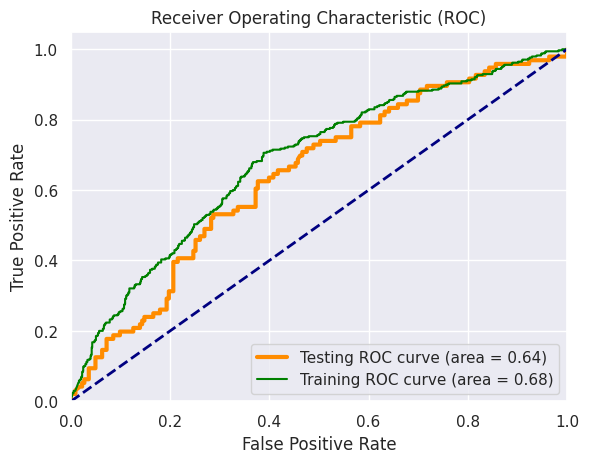

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                      
(0.00165, 0.174]       10.0           77.0     87      11.494253   
(0.174, 0.236]         23.0          128.0    151      15.231788   
(0.236, 0.278]         21.0          143.0    164      12.804878   
(0.278, 0.321]         53.0          227.0    280      18.928571   
(0.321, 0.383]        233.0          360.0    593      39.291737   

                  pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                           
(0.00165, 0.174]          88.505747           10.0               77.0   
(0.174, 0.236]            84.768212           33.0              205.0   
(0.236, 0.278]            87.195122           54.0              348.0   
(0.278, 0.321]            81.071429          107.0              575.0   
(0.321, 0.383]            60.708263          340.0              935.0   

                  cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                          
(0.00165, 0.174]         87          11.494253              88.505747  
(0.174, 0.236]          238          13.865546              86.134454  
(0.236, 0.278]          402          13.432836              86.567164  
(0.278, 0.321]          682          15.689150              84.310850  
(0.321, 0.383]         1275          26.666667              73.333333

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                      
(0.00165, 0.174]        3.0           15.0     18      16.666667   
(0.174, 0.236]          6.0           31.0     37      16.216216   
(0.236, 0.278]          7.0           31.0     38      18.421053   
(0.278, 0.321]         20.0           60.0     80      25.000000   
(0.321, 0.383]         60.0           86.0    146      41.095890   

                  pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                           
(0.00165, 0.174]          83.333333            3.0               15.0   
(0.174, 0.236]            83.783784            9.0               46.0   
(0.236, 0.278]            81.578947           16.0               77.0   
(0.278, 0.321]            75.000000           36.0              137.0   
(0.321, 0.383]            58.904110           96.0              223.0   

                  cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                          
(0.00165, 0.174]         18          16.666667              83.333333  
(0.174, 0.236]           55          16.363636              83.636364  
(0.236, 0.278]           93          17.204301              82.795699  
(0.278, 0.321]          173          20.809249              79.190751  
(0.321, 0.383]          319          30.094044              69.905956

In [129]:
with torch.no_grad():
  model.eval()
  out = model(data)
df = node_label.copy()
df[['prob1']] = out.numpy()
df[['prob1']].describe()
y_train = df.loc[df.train_mask==1,target]
y_train_proba = df.loc[df.train_mask==1,'prob1']

y_test = df.loc[df.test_mask==1,target]
y_test_proba = df.loc[df.test_mask==1,'prob1']
metrics_df = calculate_metrics(
    name = 'Edge Level – Leaky Graph Structure – UnWeighted (Model 5)',
    y_true = y_test,
    y_test_proba = df.loc[df.test_mask==1,'prob1'],
    threshold = np.median(df.loc[df.test_mask==1,'prob1'])
)
if(toggle_save == True) :
  final_results = final_results.merge(metrics_df)
else :
  display(metrics_df)
## Plotting the probabilities - They Look good and calibrated, awesome 🤩

plt.figure(figsize=(6,4))
sns.kdeplot(y_train_proba,color = 'blue',label='train',linewidth=1.5)
sns.kdeplot(y_test_proba, color = 'darkorange',label='test',linewidth=3)
plt.legend()
plt.show()
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_proba)
train_roc_auc = auc(train_fpr, train_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot(train_fpr, train_tpr, color='green', lw=1.5, label='Training ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
df['score_buckets'] = pd.qcut(df.prob1,q=buckets,duplicates='drop')
df_test = df[df.test_mask==1]
df_train = df[df.train_mask==1]
pivot_data = df_train.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})

pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']

display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])


pivot_data = df_test.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})

pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']

display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])


#### Model 6 : Edge Level – UNLeaky Graph Structure – UnWeighted

In [130]:
'''
Vectorizing the graph data
'''
#edge
edge_adj_coo =  torch.from_numpy(edge[['source', 'destination']].to_numpy(np.compat.long)).t()

#edge-attributes
edge_attr = torch.from_numpy(edge.iloc[:,:-2].to_numpy(np.float32)) #extract the features from the dataset.

#node-attribute
node_feat = torch.from_numpy(node[['degree','degree_centrality']].to_numpy(np.float32))

#graph_structure
graph_structure = torch.from_numpy(embeddings.to_numpy(np.float32))

#label
label = torch.from_numpy(node_label['dpd_7_mob_6'].to_numpy(np.float32)).unsqueeze(1)

#vectorizing the mask
train_mask  = torch.from_numpy(node_label[['train_mask']].to_numpy(np.int32))
test_mask   = torch.from_numpy(node_label[['test_mask']].to_numpy(np.int32))

In [131]:
from torch_geometric.data import Data

data = Data(
    x = node_feat,
    edge_index = edge_adj_coo,
    edge_attr = edge_attr,
    # edge_wt = edge_wt,
    y = label,
    graph_structure = graph_structure,
    train_mask = train_mask,
    test_mask = test_mask,
)

In [132]:
data

Data(x=[11367, 2], edge_index=[2, 25141], edge_attr=[25141, 256], y=[11367, 1], graph_structure=[11367, 64], train_mask=[11367, 1], test_mask=[11367, 1])

In [133]:
data.num_features

2

Model Construction & Training : Graph Attention Network (Sigmoid & BCE)

In [134]:
epochs = 20
print_step = 2
save_step = 1

In [135]:
hidden_units = 64 # for edge
hidden_units_node_attr = 4
dropout_rate = 0.2
num_features = data.num_features #data.x.shape[1]
no_of_classes = 1
no_of_graph_embedding = data.graph_structure.shape[1]
no_of_edge_features = data.edge_attr.shape[1]

In [136]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,Sequential,Linear,BatchNorm
import torch.nn as nn
from torch_geometric.nn import GATConv
import torch_geometric.transforms as T


class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.preprocessing1 = nn.BatchNorm1d(no_of_edge_features)
        self.preprocessing2 = nn.Dropout(dropout_rate)
        self.preprocessing3 = nn.Linear(no_of_edge_features, hidden_units)
        self.preprocessing4 = nn.GELU()

        self.conv1 = GATConv(in_channels = 2, out_channels = hidden_units_node_attr, edge_dim = hidden_units)
        self.conv2 = GATConv(in_channels = hidden_units_node_attr, out_channels = hidden_units_node_attr, edge_dim = hidden_units)

        self.postprocessing1 = nn.BatchNorm1d(hidden_units_node_attr+no_of_graph_embedding)
        self.postprocessing2 = nn.Dropout(dropout_rate)
        self.postprocessing3 = nn.Linear(hidden_units_node_attr+no_of_graph_embedding, hidden_units)
        self.postprocessing4 = nn.GELU()

        self.logits = Linear(hidden_units, no_of_classes)


    def forward(self, data):

        x, edge_index, edge_attr, graph_embedding = data.x, data.edge_index, data.edge_attr, data.graph_structure

        edge_attr = self.preprocessing1(edge_attr)
        edge_attr = self.preprocessing2(edge_attr)
        edge_attr = self.preprocessing3(edge_attr)
        edge_attr = self.preprocessing4(edge_attr)

        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=dropout_rate ,training=self.training)
        x = self.conv2(x, edge_index, edge_attr=edge_attr)

        x = torch.cat((x,graph_embedding),dim=1)

        x = self.postprocessing1(x)
        x = self.postprocessing2(x)
        x = self.postprocessing3(x)
        x = self.postprocessing4(x)

        x = self.logits(x)

        return torch.sigmoid(x)

In [137]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = list()
val_losses = list()

model.train()

criterion = torch.nn.BCELoss()

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)

    # loss = criterion(out, data.y)
    loss = criterion(out*data.train_mask, data.y*data.train_mask)
    val_loss = F.binary_cross_entropy(out*data.test_mask,data.y*test_mask)

    if epoch % print_step == 0:
      print("Epoch : {a} \n   Training Loss : {b}\n   Validation Loss : {c}".format(a=epoch,b=loss,c=val_loss))

    if epoch % save_step == 0:
      losses.append((epoch, loss.detach().numpy()))
      val_losses.append((epoch,val_loss.detach().numpy()))

    if epoch % save_step == 0:
        # save predictions for plotting
        model.eval()

    loss.backward()
    optimizer.step()

Epoch : 0 
   Training Loss : 0.07783577591180801
   Validation Loss : 0.0193183571100235
Epoch : 2 
   Training Loss : 0.0640484020113945
   Validation Loss : 0.01727808639407158
Epoch : 4 
   Training Loss : 0.06317821145057678
   Validation Loss : 0.017864491790533066
Epoch : 6 
   Training Loss : 0.06091877818107605
   Validation Loss : 0.0169777013361454
Epoch : 8 
   Training Loss : 0.06037166714668274
   Validation Loss : 0.016529813408851624
Epoch : 10 
   Training Loss : 0.059743188321590424
   Validation Loss : 0.016408996656537056
Epoch : 12 
   Training Loss : 0.058760080486536026
   Validation Loss : 0.01647772081196308
Epoch : 14 
   Training Loss : 0.05848364904522896
   Validation Loss : 0.016764316707849503
Epoch : 16 
   Training Loss : 0.05804138258099556
   Validation Loss : 0.016687830910086632
Epoch : 18 
   Training Loss : 0.05757651478052139
   Validation Loss : 0.01636030711233616


In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

def comparison_plot(losses,val_losses):
    '''
    Plot the trajectory of a model's training from a dataframe that has train/val loss at each epoch.
    '''
    plt.yscale('log')

    epoch, loss = tuple(zip(*losses))
    val_epoch, val_loss = tuple(zip(*val_losses))
    plt.plot(epoch, loss, color='blue', lw=1.5, label='train')
    plt.plot(val_epoch, val_loss, color='darkorange', lw=3, label='val')
    plt.legend(loc='upper right', title='model type')
    # plt.yscale('log')
    plt.ylabel('Binary Cross Entrophy')
    plt.xlabel('epoch')
    # plt.title(f'Comparing baseline and model with edge features')
    plt.show()
    plt.clf()

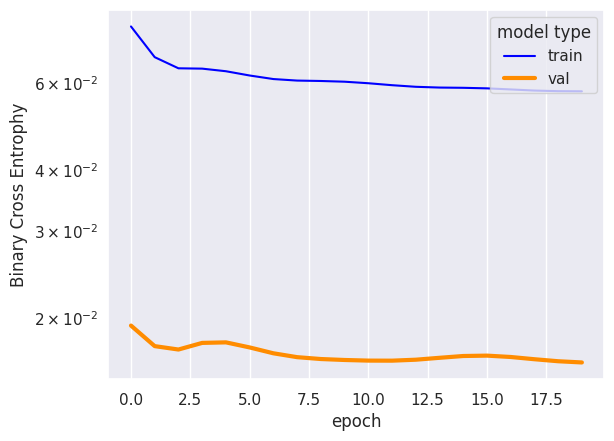

<Figure size 640x480 with 0 Axes>

In [139]:
comparison_plot(losses,val_losses)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


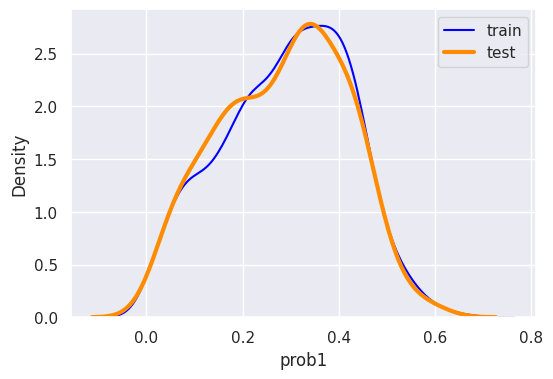

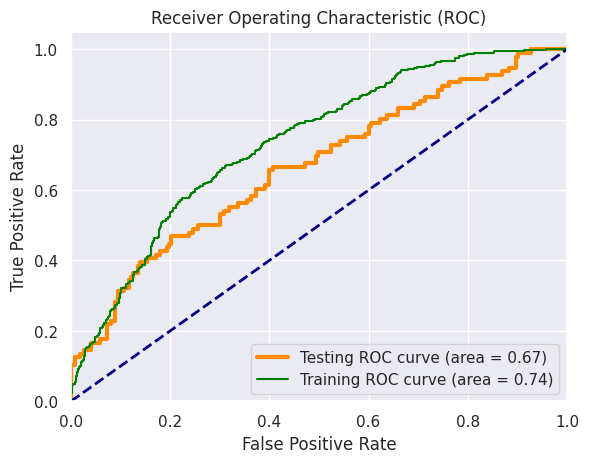

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                      
(0.00183, 0.184]       17.0          278.0    295       5.762712   
(0.184, 0.254]         41.0          150.0    191      21.465969   
(0.254, 0.316]         41.0          160.0    201      20.398010   
(0.316, 0.379]         62.0          161.0    223      27.802691   
(0.379, 0.673]        179.0          186.0    365      49.041096   

                  pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                           
(0.00183, 0.184]          94.237288           17.0              278.0   
(0.184, 0.254]            78.534031           58.0              428.0   
(0.254, 0.316]            79.601990           99.0              588.0   
(0.316, 0.379]            72.197309          161.0              749.0   
(0.379, 0.673]            50.958904          340.0              935.0   

                  cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                          
(0.00183, 0.184]        295           5.762712              94.237288  
(0.184, 0.254]          486          11.934156              88.065844  
(0.254, 0.316]          687          14.410480              85.589520  
(0.316, 0.379]          910          17.692308              82.307692  
(0.379, 0.673]         1275          26.666667              73.333333

defaulter  non_defaulter  total  pct_defaulter  \
score_buckets                                                      
(0.00183, 0.184]       15.0           69.0     84      17.857143   
(0.184, 0.254]         11.0           33.0     44      25.000000   
(0.254, 0.316]         11.0           34.0     45      24.444444   
(0.316, 0.379]         17.0           44.0     61      27.868852   
(0.379, 0.673]         42.0           43.0     85      49.411765   

                  pct_non_defaulter  cum_defaulter  cum_non_defaulter  \
score_buckets                                                           
(0.00183, 0.184]          82.142857           15.0               69.0   
(0.184, 0.254]            75.000000           26.0              102.0   
(0.254, 0.316]            75.555556           37.0              136.0   
(0.316, 0.379]            72.131148           54.0              180.0   
(0.379, 0.673]            50.588235           96.0              223.0   

                  cum_total  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                          
(0.00183, 0.184]         84          17.857143              82.142857  
(0.184, 0.254]          128          20.312500              79.687500  
(0.254, 0.316]          173          21.387283              78.612717  
(0.316, 0.379]          234          23.076923              76.923077  
(0.379, 0.673]          319          30.094044              69.905956

In [140]:
with torch.no_grad():
  model.eval()
  out = model(data)
df = node_label.copy()
df[['prob1']] = out.numpy()
df[['prob1']].describe()
y_train = df.loc[df.train_mask==1,target]
y_train_proba = df.loc[df.train_mask==1,'prob1']

y_test = df.loc[df.test_mask==1,target]
y_test_proba = df.loc[df.test_mask==1,'prob1']
metrics_df = calculate_metrics(
    name = 'Edge Level – UnLeaky Graph Structure – UnWeighted (Model 6)',
    y_true = y_test,
    y_test_proba = df.loc[df.test_mask==1,'prob1'],
    threshold = np.median(df.loc[df.test_mask==1,'prob1'])
)

if(toggle_save == True) :
  final_results = final_results.merge(metrics_df)
else :
  display(metrics_df)
## Plotting the probabilities - They Look good and calibrated, awesome 🤩

plt.figure(figsize=(6,4))
sns.kdeplot(y_train_proba,color = 'blue',label='train',linewidth=1.5)
sns.kdeplot(y_test_proba, color = 'darkorange',label='test',linewidth=3)
plt.legend()
plt.show()
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_proba)
train_roc_auc = auc(train_fpr, train_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot(train_fpr, train_tpr, color='green', lw=1.5, label='Training ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
df['score_buckets'] = pd.qcut(df.prob1,q=buckets,duplicates='drop')
df_test = df[df.test_mask==1]
df_train = df[df.train_mask==1]
pivot_data = df_train.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})

pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']

display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])


pivot_data = df_test.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})

pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']

display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])


In [141]:
final_results

Metrics  \
0                          ROC Curve   
1                            AUC-ROC   
2                       KS Statistic   
3                          Threshold   
4                           Accuracy   
5                          Precision   
6                             Recall   
7                        Specificity   
8                           F1-Score   
9                   Confusion Matrix   
10                     Cohen's Kappa   
11  Matthews Correlation Coefficient   
12                 Balanced Accuracy   

                           Just Embedding Performance  \
0   [[0.0, 0.013452914798206279, 0.022421524663677...   
1                                            0.658492   
2                                            0.288677   
3                                                 0.5   
4                                            0.636364   
5                                            0.429577   
6                                            0.635417   
7                                            0.636771   
8                                            0.512605   
9                               [[142, 81], [35, 61]]   
10                                           0.239508   
11                                           0.251204   
12                                           0.636094   

                           Classical Machine Learning  \
0   [[0.0, 0.026785714285714284, 0.026785714285714...   
1                                              0.6639   
2                                            0.303571   
3                                                 0.5   
4                                            0.615625   
5                                            0.412903   
6                                            0.666667   
7                                             0.59375   
8                                             0.50996   
9                               [[133, 91], [32, 64]]   
10                                           0.221519   
11                                           0.238792   
12                                           0.630208   

                            Using Deep Neural Network  \
0   [[0.0, 0.3705357142857143, 0.375, 0.375, 1.0],...   
1                                             0.53025   
2                                              0.0625   
3                                                 0.0   
4                                                 0.3   
5                                                 0.3   
6                                                 1.0   
7                                                 0.0   
8                                            0.461538   
9                                 [[0, 224], [0, 96]]   
10                                                0.0   
11                                                0.0   
12                                                0.5   

   Node Level – Leaky Graph Structure – UnWeighted (Model 1)  \
0   [[0.0, 0.0, 0.008968609865470852, 0.0089686098...          
1                                            0.776626          
2                                            0.452728          
3                                            0.299529          
4                                            0.655172          
5                                             0.45625          
6                                            0.760417          
7                                            0.609865          
8                                            0.570312          
9                               [[136, 87], [23, 73]]          
10                                           0.311204          
11                                           0.339674          
12                                           0.685141          

   Node Level – Leaky Graph Structure – Weighted (Model 2)  \
0   [[0.0, 0.0, 0.004484304932735426, 0.0044843049...        
1                                            0.738

#### Model 7 : Node Level – UnLeaky Graph Structure – Velocity Weighs

In [142]:
edge = pd.read_csv("data/edge_data.csv",names=['source','target','weight'],skiprows=1)

In [143]:
edge.shape

(2333, 3)

In [144]:
edge.head(2)

source       target  weight
0  81111111185  81111111185     103
1   8115934524   8115934524       1

In [145]:
node_attributes = pd.read_csv("data/node_attributes.csv")

In [146]:
node_attributes = node_attributes.iloc[:,1:]

In [147]:
print("Node attributes shape:", node_attributes.shape)
node_attributes.head()

Node attributes shape: (1595, 42)


user_id  mean_amount_M_0_PPOB  mean_amount_M_0_Payment_In  \
0  81111111185          32192.500000                         0.0   
1    811666821          31410.000000                         0.0   
2    811784808         176000.192308                         0.0   
3   8118622401              0.000000                         0.0   
4    811899969          67026.377778                         0.0   

   mean_amount_M_0_Payment_Out  mean_amount_M_0_QRIS  mean_amount_M_0_SALDO  \
0                 2.191277e+07          1.507429e+06                98636.0   
1                 5.564164e+06          0.000000e+00                68639.0   
2                 9.363182e+05          3.675000e+05                    0.0   
3                 6.892477e+05          0.000000e+00                    0.0   
4                 4.582354e+06          0.000000e+00               750000.0   

   mean_amount_M_1_PPOB  mean_amount_M_1_Payment_In  \
0          16799.333333                         0.0   
1          30048.333333                         0.0   
2         149932.815534                         0.0   
3          41336.500000                         0.0   
4          76091.040000                         0.0   

   mean_amount_M_1_Payment_Out  mean_amount_M_1_QRIS  ...  \
0                 1.730180e+07          1.423021e+06  ...   
1                 4.167113e+06          0.000000e+00  ...   
2                 1.653327e+06          2.285714e+05  ...   
3                 7.631314e+05          0.000000e+00  ...   
4                 4.824064e+06          0.000000e+00  ...   

   sum_amount_M_2_Payment_In  sum_amount_M_2_Payment_Out  sum_amount_M_2_QRIS  \
0                        0.0                0.000000e+00                  0.0   
1                        0.0                2.881464e+09                  0.0   
2                        0.0                0.000000e+00                  0.0   
3                        0.0                2.489909e+08                  0.0   
4                        0.0                1.128557e+09                  0.0   

   sum_amount_M_2_SALDO  sum_amount_M_3_PPOB  sum_amount_M_3_Payment_In  \
0                   0.0                  0.0                        0.0   
1                   0.0                  0.0                        0.0   
2                   0.0                  0.0                        0.0   
3                   0.0                  0.0                        0.0   
4             3000000.0            3664100.0                        0.0   

   sum_amount_M_3_Payment_Out  sum_amount_M_3_QRIS  sum_amount_M_3_SALDO  \
0                0.000000e+00                  0.0                   0.0   
1                2.929478e+09                  0.0                   0.0   
2                0.000000e+00                  0.0                   0.0   
3                2.766100e+08                  0.0                   0.0   
4                1.078563e+09                  0.0             2600000.0   

   dpd_7_mob_6  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 42 columns]

In [148]:
edge.shape

(2333, 3)

In [149]:
edge = edge[edge.source.isin(node_attributes.user_id.astype(int))]
edge = edge[edge.target.isin(node_attributes.user_id.astype(int))]

In [150]:
edge.shape

(1634, 3)

In [151]:
user_idc = {name: idx for idx, name in enumerate(sorted(node_attributes["user_id"].unique()))}

node_attributes["user_id"] = node_attributes["user_id"].apply(lambda name: user_idc[name])
edge["source"] = edge["source"].apply(lambda name: user_idc[name])
edge["target"] = edge["target"].apply(lambda name: user_idc[name])

In [152]:
import networkx as nx
import matplotlib.pyplot as plt
colors = node_attributes["dpd_7_mob_6"].tolist()

In [153]:
cora_graph = nx.from_pandas_edgelist(edge,source='source', target='target',edge_attr='weight')

In [154]:
len(cora_graph.nodes)

1175

In [155]:
#nodes missing from the graphs
new_nodes = node_attributes[~node_attributes.user_id.isin(list(cora_graph.nodes))].user_id

In [156]:
len(new_nodes)

419

In [157]:
new_nodes

7         73
23        17
24        90
27        94
41       113
        ... 
1574    1035
1578    1593
1579     744
1582    1491
1586     742
Name: user_id, Length: 419, dtype: int64

In [158]:
cora_graph.add_nodes_from(new_nodes)

In [159]:
len(cora_graph.nodes)

1594

In [160]:
node_attributes.user_id.nunique(), node_attributes.user_id.shape[0]

(1594, 1595)

In [161]:
node_attributes = node_attributes.drop_duplicates()

In [162]:
node_attributes.dpd_7_mob_6.isnull().sum()

0

In [163]:
# subjects = list(node_attributes[node_attributes["user_id"].isin(list(cora_graph.nodes))]["dpd_7_mob_6"])
# len(subjects)

In [164]:
# plt.figure(figsize=(10, 10))

# nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [165]:
from sklearn.decomposition import PCA
from karateclub import DeepWalk

# train model and generate embedding
model = DeepWalk(walk_length=10, dimensions=64, window_size=3)
model.fit(cora_graph)
embedding = model.get_embedding()

In [166]:
embeddings = pd.DataFrame(embedding)
embeddings = embeddings.add_prefix("G_struc_emb_")
embeddings = embeddings.reset_index().rename(columns={'index':'user_idc'})

In [167]:
embeddings.head(2)

user_idc  G_struc_emb_0  G_struc_emb_1  G_struc_emb_2  G_struc_emb_3  \
0         0       0.019878       0.630160       0.852478       0.526062   
1         1       0.532351      -0.272571       1.815735       0.959695   

   G_struc_emb_4  G_struc_emb_5  G_struc_emb_6  G_struc_emb_7  G_struc_emb_8  \
0       1.027455      -0.424986      -0.675834      -0.209423       0.661619   
1       1.193284      -0.148708      -1.710203      -1.007895       0.041972   

   ...  G_struc_emb_54  G_struc_emb_55  G_struc_emb_56  G_struc_emb_57  \
0  ...       -0.343686       -0.293230       -0.221368        0.174254   
1  ...       -1.352662       -0.213458        0.184817       -0.983776   

   G_struc_emb_58  G_struc_emb_59  G_struc_emb_60  G_struc_emb_61  \
0       -1.147621        0.672582        0.893794       -0.083127   
1       -0.262390        0.993917        0.558609       -0.950409   

   G_struc_emb_62  G_struc_emb_63  
0        0.306696        0.254410  
1        0.151189        0.522768  

[2 rows x 65 columns]

In [168]:
# load node attribute & label

node_attributes['degree'] = node_attributes.user_id.map(nx.degree(cora_graph))
node_attributes['degree_centrality'] = node_attributes.user_id.map(nx.degree_centrality(cora_graph))
node_attributes['closeness_centrality'] = node_attributes.user_id.map(nx.closeness_centrality(cora_graph))
node_attributes['betweenness_centrality'] = node_attributes.user_id.map(nx.betweenness_centrality(cora_graph))

In [169]:
node_attributes = node_attributes.merge(embeddings, left_on='user_id',right_on='user_idc')

In [170]:
max(user_idc.values())

1593

In [171]:
test_users_idc = X_test_original.user_id.astype(int).map(user_idc).values

node_attributes['test_mask'] = node_attributes.user_id.isin(test_users_idc).astype(int)
node_attributes['train_mask'] = (~node_attributes.user_id.isin(test_users_idc)).astype(int)

In [172]:
node_attributes.test_mask.sum() + node_attributes.train_mask.sum()

1594

In [173]:
edge.rename(columns={'target':'destination'},inplace=True)

In [174]:
pseudo_edge_attr = pd.read_csv("data/rnn_out_edge_based_256Rd.csv").iloc[:,6:].drop('edge_pair',axis=1)
pseudo_edge_attr = pseudo_edge_attr[pseudo_edge_attr.destination.str.isnumeric()]
pseudo_edge_attr['source'] = pseudo_edge_attr.source.map(user_idc)
pseudo_edge_attr['destination'] = pseudo_edge_attr.destination.astype(int).map(user_idc)
pseudo_edge_attr['edge_pair'] = pseudo_edge_attr['source'].astype('Int64').astype(str) + "_" + pseudo_edge_attr['destination'].astype('Int64').astype(str)

In [175]:
edge['edge_pair'] = edge['source'].astype(str) + "_" + edge['destination'].astype(str)

In [176]:
edge_attr = edge.merge(pseudo_edge_attr.drop(['source','destination'],axis=1), on = 'edge_pair')

In [177]:
graph_structure_feature_names = ["G_struc_emb_"+str(i) for i in range(64)]

In [178]:
node_feature_names = set(node_attributes.drop(['user_id','user_idc','dpd_7_mob_6','train_mask','test_mask'],axis=1).columns) - set(["G_struc_emb_"+str(i) for i in range(64)])

In [179]:
edge_attr[['source','destination']] = edge_attr[['source','destination']].astype(int)

In [180]:
'''
Vectorizing the graph data
'''
# edge
edge_adj_coo =  torch.from_numpy(edge_attr[['source', 'destination']].to_numpy(np.compat.long)).t()

# edge-attributes
edge_attr = torch.from_numpy(edge_attr.iloc[:,4:].to_numpy(np.float32))

# node-attribute
node_feat = torch.from_numpy(node_attributes[node_feature_names].to_numpy(np.float32))

# graph_structure (deep_walk)
graph_structure = torch.from_numpy(node_attributes[graph_structure_feature_names].to_numpy(np.float32))

# label
label = torch.from_numpy(node_attributes[target].to_numpy(np.float32)).unsqueeze(1)

# making masks
train_mask = torch.from_numpy(node_attributes['train_mask'].to_numpy(np.int32))
test_mask = torch.from_numpy(node_attributes['test_mask'].to_numpy(np.int32))

In [181]:
from torch_geometric.data import Data

data = Data(
    x = node_feat,
    edge_index = edge_adj_coo,
    edge_attr = edge_attr,
    # edge_wt = edge_wt,
    y = label,
    graph_structure = graph_structure,
    train_mask = train_mask,
    test_mask = test_mask,
)

In [182]:
data

Data(x=[1594, 44], edge_index=[2, 1633], edge_attr=[1633, 256], y=[1594, 1], graph_structure=[1594, 64], train_mask=[1594], test_mask=[1594])

In [183]:
data.num_features

44

Model Construction & Training : Graph Attention Network (Sigmoid & BCE)



In [184]:
epochs = 50
print_step = 2
save_step = 4

hidden_units_edge_attr = 1
hidden_units_node_attr = 128
hidden_units_node_attr2 = 64
hidden_units = 32
dropout_rate = 0.2
no_of_classes = 1

num_features = data.num_features #data.x.shape[1]
no_of_graph_embedding = data.graph_structure.shape[1]
no_of_edge_features = data.edge_attr.shape[1]

In [185]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,Sequential,Linear,BatchNorm
import torch.nn as nn
from torch_geometric.nn import GATConv
import torch_geometric.transforms as T


class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.preprocessing1A = nn.BatchNorm1d(no_of_edge_features)
        self.preprocessing2A = nn.Dropout(dropout_rate)
        self.preprocessing3A = nn.Linear(no_of_edge_features, 32)
        self.preprocessing4A = nn.GELU()
        self.preprocessing5A = nn.Dropout(dropout_rate)
        self.preprocessing6A = nn.Linear(32, 1)
        self.preprocessing7A = nn.ReLU()

        self.preprocessing1B = nn.BatchNorm1d(num_features)
        self.preprocessing2B = nn.Dropout(dropout_rate)
        self.preprocessing3B = nn.Linear(num_features, hidden_units_node_attr)
        self.preprocessing4B = nn.GELU()


        self.conv1 = GCNConv(hidden_units_node_attr, hidden_units_node_attr2)
        self.conv2 = GCNConv(hidden_units_node_attr2, hidden_units_node_attr2)

        # self.conv1 = GATConv(in_channels = hidden_units_node_attr, out_channels = hidden_units_node_attr2, edge_dim = hidden_units_edge_attr)
        # self.conv2 = GATConv(in_channels = hidden_units_node_attr2, out_channels = hidden_units_node_attr2, edge_dim = hidden_units_edge_attr)

        self.postprocessing1 = nn.BatchNorm1d(hidden_units_node_attr2+no_of_graph_embedding)
        self.postprocessing2 = nn.Dropout(dropout_rate)
        self.postprocessing3 = nn.Linear(hidden_units_node_attr2+no_of_graph_embedding, hidden_units)
        self.postprocessing4 = nn.GELU()

        self.logits = Linear(hidden_units, no_of_classes)


    def forward(self, data):

        x, edge_index, edge_attr, graph_embedding = data.x, data.edge_index, data.edge_attr, data.graph_structure

        edge_weight = self.preprocessing1A(edge_attr) #note
        edge_weight = self.preprocessing2A(edge_weight)
        edge_weight = self.preprocessing3A(edge_weight)
        edge_weight = self.preprocessing4A(edge_weight)
        edge_weight = self.preprocessing5A(edge_weight)
        edge_weight = self.preprocessing6A(edge_weight)
        edge_weight = self.preprocessing7A(edge_weight)

        x = self.preprocessing1B(x)
        x = self.preprocessing2B(x)
        x = self.preprocessing3B(x)
        x = self.preprocessing4B(x)

        # x = self.conv1(x, edge_index, edge_attr=edge_attr)
        # x = F.relu(x)
        # x = F.dropout(x, p=dropout_rate ,training=self.training)
        # x = self.conv2(x, edge_index, edge_attr=edge_attr)

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)

        x = torch.cat((x,graph_embedding),dim=1)

        x = self.postprocessing1(x)
        x = self.postprocessing2(x)
        x = self.postprocessing3(x)
        x = self.postprocessing4(x)

        x = self.logits(x)

        return torch.sigmoid(x)

In [186]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = list()
val_losses = list()

model.train()

criterion = torch.nn.BCELoss()

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)

    # loss = criterion(out, data.y)
    loss = criterion(out*data.train_mask, data.y*data.train_mask)
    val_loss = F.binary_cross_entropy(out*data.test_mask,data.y*test_mask)

    if epoch % print_step == 0:
      print("Epoch : {a} \n   Training Loss : {b}\n   Validation Loss : {c}".format(a=epoch,b=loss,c=val_loss))

    if epoch % save_step == 0:
      losses.append((epoch, loss.detach().numpy()))
      val_losses.append((epoch,val_loss.detach().numpy()))

    if epoch % save_step == 0:
        # save predictions for plotting
        model.eval()

    loss.backward()
    optimizer.step()

Epoch : 0 
   Training Loss : 0.5918892025947571
   Validation Loss : 0.14808835089206696
Epoch : 2 
   Training Loss : 0.47423604130744934
   Validation Loss : 0.11865201592445374
Epoch : 4 
   Training Loss : 0.4798263609409332
   Validation Loss : 0.12005066871643066
Epoch : 6 
   Training Loss : 0.44288110733032227
   Validation Loss : 0.11080712080001831
Epoch : 8 
   Training Loss : 0.44903528690338135
   Validation Loss : 0.11234685778617859
Epoch : 10 
   Training Loss : 0.44029101729393005
   Validation Loss : 0.11015907675027847
Epoch : 12 
   Training Loss : 0.4331304728984833
   Validation Loss : 0.10836754739284515
Epoch : 14 
   Training Loss : 0.4271402060985565
   Validation Loss : 0.10686880350112915
Epoch : 16 
   Training Loss : 0.42000141739845276
   Validation Loss : 0.10508271306753159
Epoch : 18 
   Training Loss : 0.41300150752067566
   Validation Loss : 0.10333135724067688
Epoch : 20 
   Training Loss : 0.40399158000946045
   Validation Loss : 0.101077117025852

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

def comparison_plot(losses,val_losses):
    '''
    Plot the trajectory of a model's training from a dataframe that has train/val loss at each epoch.
    '''
    plt.yscale('log')

    epoch, loss = tuple(zip(*losses))
    val_epoch, val_loss = tuple(zip(*val_losses))
    plt.plot(epoch, loss, color='blue', lw=1.5, label='train')
    plt.plot(val_epoch, val_loss, color='darkorange', lw=3, label='val')
    plt.legend(loc='upper right', title='model type')
    # plt.yscale('log')
    plt.ylabel('Binary Cross Entrophy')
    plt.xlabel('epoch')
    # plt.title(f'Comparing baseline and model with edge features')
    plt.show()
    plt.clf()

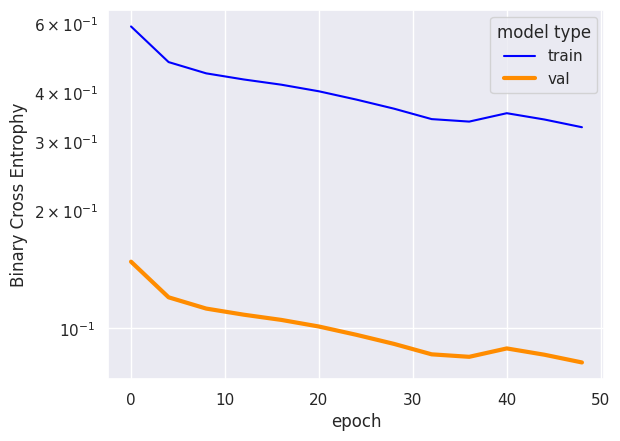

<Figure size 640x480 with 0 Axes>

In [188]:
comparison_plot(losses,val_losses)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


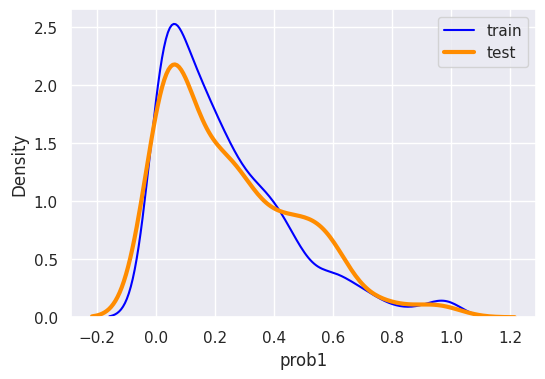

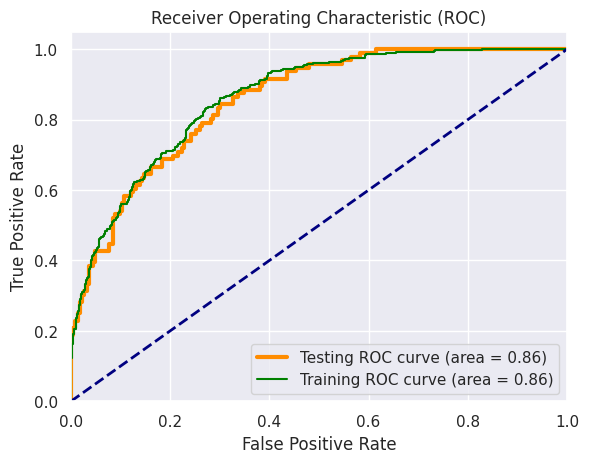

defaulter  non_defaulter  total  \
score_buckets                                                       
(-0.0009999999999999979, 0.0473]          2            248    250   
(0.0473, 0.132]                          13            247    260   
(0.132, 0.241]                           56            211    267   
(0.241, 0.411]                          103            158    261   
(0.411, 1.0]                            166             71    237   

                                  pct_defaulter  pct_non_defaulter  \
score_buckets                                                        
(-0.0009999999999999979, 0.0473]       0.800000          99.200000   
(0.0473, 0.132]                        5.000000          95.000000   
(0.132, 0.241]                        20.973783          79.026217   
(0.241, 0.411]                        39.463602          60.536398   
(0.411, 1.0]                          70.042194          29.957806   

                                  cum_defaulter  cum_non_defaulter  cum_total  \
score_buckets                                                                   
(-0.0009999999999999979, 0.0473]              2                248        250   
(0.0473, 0.132]                              15                495        510   
(0.132, 0.241]                               71                706        777   
(0.241, 0.411]                              174                864       1038   
(0.411, 1.0]                                340                935       1275   

                                  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                               
(-0.0009999999999999979, 0.0473]           0.800000              99.200000  
(0.0473, 0.132]                            2.941176              97.058824  
(0.132, 0.241]                             9.137709              90.862291  
(0.241, 0.411]                            16.763006              83.236994  
(0.411, 1.0]                              26.666667              73.333333

defaulter  non_defaulter  total  \
score_buckets                                                       
(-0.0009999999999999979, 0.0473]          0             69     69   
(0.0473, 0.132]                           6             53     59   
(0.132, 0.241]                           13             38     51   
(0.241, 0.411]                           21             37     58   
(0.411, 1.0]                             56             26     82   

                                  pct_defaulter  pct_non_defaulter  \
score_buckets                                                        
(-0.0009999999999999979, 0.0473]       0.000000         100.000000   
(0.0473, 0.132]                       10.169492          89.830508   
(0.132, 0.241]                        25.490196          74.509804   
(0.241, 0.411]                        36.206897          63.793103   
(0.411, 1.0]                          68.292683          31.707317   

                                  cum_defaulter  cum_non_defaulter  cum_total  \
score_buckets                                                                   
(-0.0009999999999999979, 0.0473]              0                 69         69   
(0.0473, 0.132]                               6                122        128   
(0.132, 0.241]                               19                160        179   
(0.241, 0.411]                               40                197        237   
(0.411, 1.0]                                 96                223        319   

                                  cum_pct_defaulter  cum_pct_non_defaulter  
score_buckets                                                               
(-0.0009999999999999979, 0.0473]           0.000000             100.000000  
(0.0473, 0.132]                            4.687500              95.312500  
(0.132, 0.241]                            10.614525              89.385475  
(0.241, 0.411]                            16.877637              83.122363  
(0.411, 1.0]                              30.094044              69.905956

In [189]:
with torch.no_grad():
  model.eval()
  out = model(data)
df = node_attributes.copy()
df[['prob1']] = out.numpy()
df[['prob1']].describe()
y_train = df.loc[df.train_mask==1,target]
y_train_proba = df.loc[df.train_mask==1,'prob1']

y_test = df.loc[df.test_mask==1,target]
y_test_proba = df.loc[df.test_mask==1,'prob1']
metrics_df = calculate_metrics(
    name = 'Node Level – UnLeaky Graph Structure – Velocity Weighs (Model 7)',
    y_true = y_test,
    y_test_proba = df.loc[df.test_mask==1,'prob1'],
    threshold = np.median(df.loc[df.test_mask==1,'prob1'])
)

if(toggle_save == True) :
  final_results = final_results.merge(metrics_df)
else :
  display(metrics_df)
## Plotting the probabilities - They Look good and calibrated, awesome 🤩

plt.figure(figsize=(6,4))
sns.kdeplot(y_train_proba,color = 'blue',label='train',linewidth=1.5)
sns.kdeplot(y_test_proba, color = 'darkorange',label='test',linewidth=3)
plt.legend()
plt.show()
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_proba)
train_roc_auc = auc(train_fpr, train_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=3, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot(train_fpr, train_tpr, color='green', lw=1.5, label='Training ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
df['score_buckets'] = pd.qcut(df.prob1,q=buckets,duplicates='drop')
df_test = df[df.test_mask==1]
df_train = df[df.train_mask==1]
pivot_data = df_train.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})

pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']

display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])
## LoL same name PD :P
pivot_data = df_test.pivot_table(index ='score_buckets', values = target, aggfunc={
    target:['count','sum'],
}).rename(columns={'count':'total','sum':'defaulter'})

pivot_data['non_defaulter'] = pivot_data.total - pivot_data.defaulter
pivot_data['pct_defaulter'] = pivot_data.defaulter/pivot_data.total*100
pivot_data['pct_non_defaulter'] = 100 - pivot_data['pct_defaulter']
pivot_data['cum_defaulter'] = pivot_data.defaulter.cumsum()
pivot_data['cum_non_defaulter'] = pivot_data.non_defaulter.cumsum()
pivot_data['cum_total'] =  pivot_data.total.cumsum()
pivot_data['cum_pct_defaulter'] = pivot_data.cum_defaulter/pivot_data.cum_total*100
pivot_data['cum_pct_non_defaulter'] = 100 - pivot_data['cum_pct_defaulter']

display(
    pivot_data[[
          'defaulter',
          'non_defaulter',
          'total',
          'pct_defaulter',
          'pct_non_defaulter',
          'cum_defaulter',
          'cum_non_defaulter',
          'cum_total',
          'cum_pct_defaulter',
          'cum_pct_non_defaulter'
    ]])
## LoL same name PD :P

### Final Results

In [190]:
final_results = final_results.set_index('Metrics')

In [191]:
final_results.drop('Just Embedding Performance',axis=1).drop(['ROC Curve','Confusion Matrix'],axis=0)

Classical Machine Learning  \
Metrics                                                       
AUC-ROC                                              0.6639   
KS Statistic                                       0.303571   
Threshold                                               0.5   
Accuracy                                           0.615625   
Precision                                          0.412903   
Recall                                             0.666667   
Specificity                                         0.59375   
F1-Score                                            0.50996   
Cohen's Kappa                                      0.221519   
Matthews Correlation Coefficient                   0.238792   
Balanced Accuracy                                  0.630208   

                                 Using Deep Neural Network  \
Metrics                                                      
AUC-ROC                                            0.53025   
KS Statistic                                        0.0625   
Threshold                                              0.0   
Accuracy                                               0.3   
Precision                                              0.3   
Recall                                                 1.0   
Specificity                                            0.0   
F1-Score                                          0.461538   
Cohen's Kappa                                          0.0   
Matthews Correlation Coefficient                       0.0   
Balanced Accuracy                                      0.5   

                                 Node Level – Leaky Graph Structure – UnWeighted (Model 1)  \
Metrics                                                                                      
AUC-ROC                                                                    0.776626          
KS Statistic                                                               0.452728          
Threshold                                                                  0.299529          
Accuracy                                                                   0.655172          
Precision                                                                   0.45625          
Recall                                                                     0.760417          
Specificity                                                                0.609865          
F1-Score                                                                   0.570312          
Cohen's Kappa                                                              0.311204          
Matthews Correlation Coefficient                                           0.339674          
Balanced Accuracy                                                          0.685141          

                                 Node Level – Leaky Graph Structure – Weighted (Model 2)  \
Metrics                                                                                    
AUC-ROC                                                                    0.738836        
KS Statistic                                                                0.42699        
Threshold                                                                   0.22606        
Accuracy                                                                   0.667712        
Precision                                                                   0.46875        
Recall                                                                      0.78125        
Specificity                                                                0.618834        
F1-Score                                                                   0.585938        
Cohen's Kappa                                                              0.336252        
Matthews Correlation Coefficient                                           0.367012        
Balanced Accuracy                                                          0.70

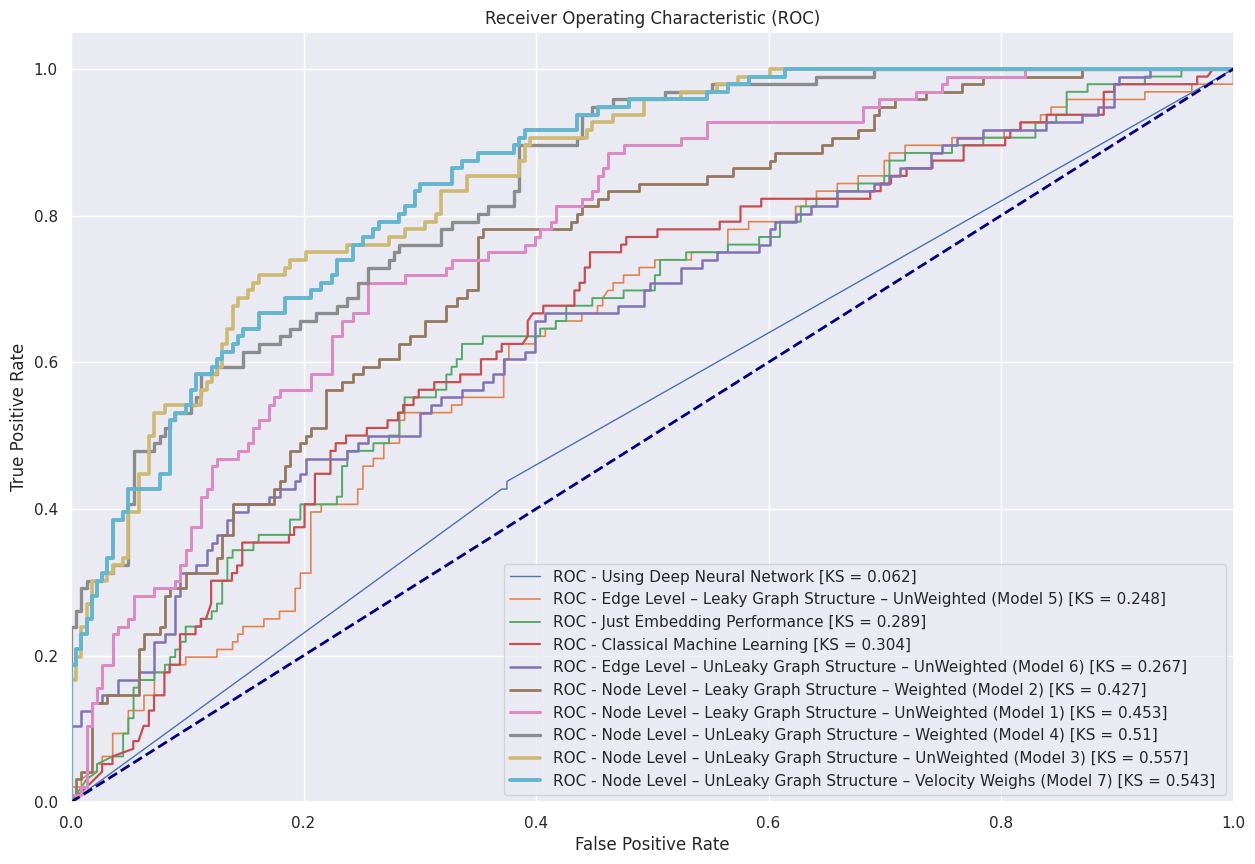

In [193]:
# Plot the ROC curve
plt.figure(figsize=(15,10))

for weight,i in enumerate(final_results.sort_values('AUC-ROC',axis=1).columns):
  x = final_results.loc['ROC Curve',i]
  y = np.round(final_results.loc['KS Statistic',i],3)
  fpr,tpr,threshold = x
  plt.plot(fpr, tpr, lw=(1+0.2*weight), label='ROC - {name} [KS = {auc}] '.format(name=i,auc=y), linestyle='-')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [194]:
final_results.reset_index(inplace=True)